# **Google Analytics 360**
# New Customer Acquisition Lifetime Value Prediction
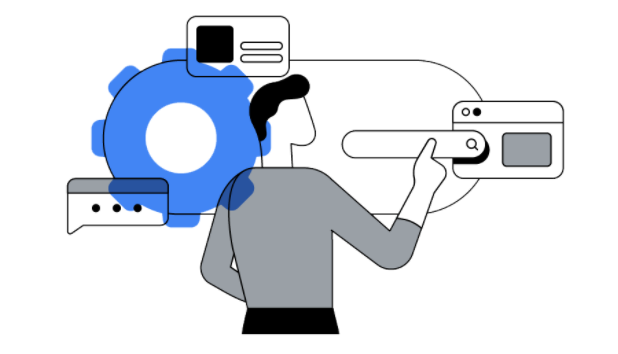

This notebook provides an example of training a customer "lifetime" value model for newly acquired e-commerce customers. It is meant to outline the minimum steps required to train this type of model and can be used as a starting point for your project. It is **not** meant to illustrate best practices or preferred approaches for this type of modeling.

The notebook references publicly available sample of Analytics 360 data, which is accessible through Google Cloud Platform's BigQuery data warehouse. The data was collected from the Google Merchandise Store, which sells Google promotional products like t-shirts, pens, phone accessories, mugs, etc.

For each newly acquired customer, we would like to make an estimate of the *future* revenue we can expect from this customer. We will make a prediction one week after the customer is acquired to estimate their revenue up to 90 days after their acquisition date. By combining this predicted revenue with the actual revenue generated from the customer's first purchase and any subsequent purchase during their first week, we can get a more hollistic view of the value of the acquisition. By providing this value (first transaction revenue + subsequent week 1 revenue + day 8-90 predicted revenue) to Google advertising platforms, Google can automatically optimize digital ads to help acquire higher value new customers.

## Creating training, testing & holdout datasets

In [ ]:
# Authenticate using Google OAuth 2.0
# This will provide the credentials necessary to use Google APIs within this notebook (e.g. BigQuery API)
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Query the Analytics 360 sample in BigQuery and store results as a Pandas dataframe
import pandas as pd
import numpy as np
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

# Change the project to the ID of your personal GCP project
# You can find this ID by going to BQ, clicking on your project name at the top of the UI and finding the ID listed for your project name in the pop-up
project = 'gcp-project-339902'

credentials, project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bqclient = bigquery.Client(credentials=credentials, project=project,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

# The query below finds the first transaction of each customer before 05/01/2017
# It summarizes some information from the session where that transaction occurred (e.g. revenue, time on site, page views, etc.)
# It then summarizes some information from subsequent sessions that happen within 7 days of the first transaction session (e.g. additional visits, additional transactions)
# It then sums any subsequent revenue received from that customer over the next 8-90 days, which will be the target for our model
# Again, this is only example query. Feel free to edit and expand on this query to generate better features or a different dataset structure.
# (For example, you could also include data from sessions that happened *before* the customer's acquisition session to help make your prediction...Just don't include data from more than 7 days after their acquisition session!)
# Comments are added within the query. You can copy & paste this query into the BigQuery UI for easier readability
sql = """
WITH first_purchases AS (
# Find the start time for the session when the customer made their first purchase
SELECT 
    fullVisitorId, # Consider this the customer ID
    MIN(PARSE_TIMESTAMP('%s', CAST(visitStartTime AS string))) firstPurchaseSessionTime # This will show "UTC" as the timezone but I think it's actually Pacific
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND geoNetwork.country = 'United States' # Only looking at US acquisitions so we can assume everything is in USD
GROUP BY
    fullVisitorId
),

first_purchases_sessions AS (
# Get session-level data from the session when the customer made their first purchase
# You'll see later that we have to query session-level data and hit-level data separately
SELECT 
    fp.fullVisitorId,
    ROUND(SUM(totals.transactionRevenue/1000000),2) AS revenue, # I've aggregated all the metrics here but really I don't have to since these are "totals" fields (i.e. session-level) and there will only be one session per customer
    MAX(visitNumber) AS visitNumber,
    SUM(totals.hits) AS hits,
    SUM(totals.pageviews) AS pageviews,
    COALESCE(SUM(totals.timeOnSite),0) AS timeOnSite,
    COALESCE(SUM(totals.newVisits), 0) AS newVisits,
    MAX(CASE WHEN channelGrouping = 'Referral' THEN 1 ELSE 0 END) AS referralChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Organic Search' THEN 1 ELSE 0 END) AS organicSearchChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Direct' THEN 1 ELSE 0 END) AS directChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Paid Search' THEN 1 ELSE 0 END) AS paidSearchChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Affiliates' THEN 1 ELSE 0 END) affiliatesChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Display' THEN 1 ELSE 0 END) displayChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Social' THEN 1 ELSE 0 END) socialChannelGrouping,
    MAX(CASE WHEN device.browser = 'Chrome' THEN 1 ELSE 0 END) AS chromeBrowser,
    MAX(CASE WHEN device.browser = 'Safari' THEN 1 ELSE 0 END) AS safariBrowser,
    MAX(CASE WHEN device.operatingSystem = 'Macintosh' THEN 1 ELSE 0 END) AS macintoshOS,
    MAX(CASE WHEN device.operatingSystem = 'Windows' THEN 1 ELSE 0 END) AS windowsOS,
    MAX(CASE WHEN device.operatingSystem = 'Chrome OS' THEN 1 ELSE 0 END) AS chromeOS,
    MAX(CASE WHEN device.operatingSystem = 'Linux' THEN 1 ELSE 0 END) AS LinuxOS,
    MAX(CASE WHEN device.operatingSystem = 'iOS' THEN 1 ELSE 0 END) AS iOSOS,
    MAX(CASE WHEN device.operatingSystem = 'Android' THEN 1 ELSE 0 END) AS AndroidOS,
    MAX(CASE WHEN device.operatingSystem = 'Windows Phone' THEN 1 ELSE 0 END) AS WindowsPhone,
    MAX(CASE WHEN device.isMobile IS TRUE THEN 1 ELSE 0 END) AS isMobile, # dummy variable indicating if the customer was on a mobile device
    MAX(CASE WHEN geoNetwork.region = 'California' THEN 1 ELSE 0 END) AS california, # dummy variable indicating if the customer was in California
    MAX(CASE WHEN geoNetwork.region = 'New York' THEN 1 ELSE 0 END) AS newYork, # dummy variable indicating if the customer was in California
    MAX(CASE WHEN geoNetwork.metro = 'San Francisco-Oakland-San Jose CA' THEN 1 ELSE 0 END) AS bayArea,
    MAX(CASE WHEN trafficSource.source like 'google%' THEN 1 ELSE 0 END) AS GoogleURL,
    MAX(CASE WHEN trafficSource.medium = 'organic' THEN 1 ELSE 0 END) AS Organic,
    MAX(CASE WHEN trafficSource.medium = 'referral' THEN 1 ELSE 0 END) AS Referral,
    MAX(CASE WHEN device.deviceCategory = 'mobile' THEN 1 ELSE 0 END) AS mobile,
    MAX(CASE WHEN trafficSource.keyword = 'google merchandise store' THEN 1 ELSE 0 END) AS googlemerchandisestore,
    MAX(CASE WHEN trafficSource.keyword = 'google merchandise' THEN 1 ELSE 0 END) AS googlemerchandise,
    MAX(CASE WHEN trafficSource.keyword = '6qEhsCssdK0z36ri' THEN 1 ELSE 0 END) AS URLKeyword,
    MAX(CASE WHEN geoNetwork.metro = 'Washington DC (Hagerstown MD)' THEN 1 ELSE 0 END) AS DC,
    MAX(CASE WHEN geoNetwork.metro = 'Indianapolis IN' THEN 1 ELSE 0 END) AS Indianapolis,
    MAX(CASE WHEN geoNetwork.metro = 'Houston TX' THEN 1 ELSE 0 END) AS Houston,
    MAX(CASE WHEN geoNetwork.metro = 'Pittsburgh PA' THEN 1 ELSE 0 END) AS Pittsburgh,
    MAX(CASE WHEN geoNetwork.metro = 'Phoenix AZ' THEN 1 ELSE 0 END) AS Phoenix,
    MAX(CASE WHEN geoNetwork.metro = 'Omaha NE' THEN 1 ELSE 0 END) AS Omaha,
    MAX(CASE WHEN geoNetwork.metro = 'Philadelphia PA' THEN 1 ELSE 0 END) AS Philadelphia,
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
JOIN
    first_purchases fp
ON
    ga.fullVisitorId = fp.fullVisitorId
    AND PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)) = fp.firstPurchaseSessionTime # Only getting data from first purchase
WHERE
    _TABLE_SUFFIX < '20170501' 
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND geoNetwork.country = 'United States'
GROUP BY
    fp.fullVisitorId
),

first_purchases_hits AS (
# Get hit-level data from the session when the customer made their first purchase
# Hit data is stored in nested fields so we have to query it separately from the session-level data or else the session-level data aggregations would be incorrect
SELECT 
    fp.fullVisitorId,
    SUM(CASE WHEN hits.eCommerceAction.action_type = '6' THEN product.productQuantity ELSE 0 END) AS productQuantityPurchased, # Product quantity in the final transaction
    MAX(CASE WHEN product.v2ProductCategory = 'Apparel' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS apparelPurchased, # dummy variable indicating if any apparel was purchased
    MAX(CASE WHEN product.v2ProductCategory = 'Office' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS officePurchased,# dummy variable indicating if any office supplies were purchased
    MAX(CASE WHEN product.v2ProductCategory = 'Drinkware' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS drinkwarePurchased,
    MAX(CASE WHEN product.v2ProductCategory = 'Lifestyle' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS lifestylePurchased,
    MAX(CASE WHEN product.v2ProductCategory = 'Bags' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS bagsPurchased,
    MAX(CASE WHEN product.v2ProductCategory = 'Electronics' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS electronicsPurchased,# dummy variable indicating if any electronics were purchased
    MAX(CASE WHEN hits.eCommerceAction.action_type = '4' THEN 1 ELSE 0 END) AS removedItemFromCart # dummy variable indicating if they removed something from their cart during the session
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga,
    UNNEST(hits) hits,
    UNNEST(hits.product) product

JOIN
    first_purchases fp
ON
    ga.fullVisitorId = fp.fullVisitorId
    AND PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)) = fp.firstPurchaseSessionTime # Only getting data from first purchase
WHERE
    _TABLE_SUFFIX < '20170501' 
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND geoNetwork.country = 'United States'
GROUP BY
    fp.fullVisitorId
),

# Get session level data that occured after the first purchase session but within 7 days of that session
# Looking to see if the user came back within a week and had any additional activity
first_week_sessions AS (
SELECT 
    fp.fullVisitorId,
    COALESCE(SUM(ga.totals.visits),0) AS firstWeekVisits, # Visits from first week of acquisition, excluding acquisition session
    COALESCE(SUM(ga.totals.transactions),0) AS firstWeekTransactions, # Transactions from first week of acquisition, excluding acquisition session
    COALESCE(ROUND(SUM(ga.totals.transactionRevenue/1000000),2),0) AS firstWeekRevenue, # Revenue from first week of acquisition, excluding acquisition session
FROM 
    first_purchases fp
LEFT JOIN
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
ON 
    fp.fullVisitorId = ga.fullVisitorId
    AND TIMESTAMP_DIFF(PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)), fp.firstPurchaseSessionTime, HOUR) BETWEEN 1 AND 168 # Consider visits between 1 hour and 7 days after first purchase session
GROUP BY 
    fp.fullVisitorId
),

future_purchases AS (
# For each newly acquired customer, look for any purchases that occurred in the next 8-90 days
SELECT
    fp.fullVisitorId,
    ROUND(SUM(ga.totals.transactionRevenue/1000000),2) AS futureRevenue # This is our model target
FROM 
    first_purchases fp
LEFT JOIN
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
ON 
    fp.fullVisitorId = ga.fullVisitorId
    AND TIMESTAMP_DIFF(PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)), fp.firstPurchaseSessionTime, DAY) BETWEEN 8 AND 90 # Consider purchases between 8-90 days after acquisition
WHERE 
    ga.totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY 
    fp.fullVisitorId
)

# Join the list of newly acquired customers to their acquisition session-level data, acquisition hit-level data, first week session-level data, and future day 8-90 revenue
SELECT
    first_purchases.*,
    first_purchases_sessions.* EXCEPT(fullVisitorId),
    first_purchases_hits.* EXCEPT(fullVisitorId),
    first_week_sessions.* EXCEPT(fullVisitorId),
    COALESCE(future_purchases.futureRevenue,0) AS futureRevenue
FROM 
    first_purchases
LEFT JOIN 
    first_purchases_sessions 
USING(fullVisitorId)
LEFT JOIN 
    first_purchases_hits 
USING(fullVisitorId)
LEFT JOIN 
    future_purchases 
USING(fullVisitorId)
LEFT JOIN
    first_week_sessions 
USING(fullVisitorId)
"""

# Store query results as Panada dataframe
df = pd.read_gbq(sql, project_id=project, dialect='standard', use_bqstorage_api=True)

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery_storage_v1beta1/reader.py:603: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


In [ ]:
df.head()

fullVisitorId  firstPurchaseSessionTime  revenue  visitNumber  hits  \
0  9089132392240687728 2016-10-13 01:06:58+00:00   761.25            1    83   
1  7284466025557220497 2016-11-01 19:19:42+00:00   935.63            8    55   
2  0717343852152056082 2017-04-06 17:43:00+00:00   167.65           12    12   
3  7671938929886422316 2017-04-18 01:34:31+00:00    75.03            5    48   
4   437357987201411491 2017-01-13 06:57:04+00:00  1137.35            3    40   

   pageviews  timeOnSite  newVisits  referralChannelGrouping  \
0         69        1849          1                        0   
1         39         732          0                        0   
2         10        1343          0                        1   
3         37        1745          0                        1   
4         34         579          0                        0   

   organicSearchChannelGrouping  ...  officePurchased  drinkwarePurchased  \
0                             0  ...                0                   0   
1                             0  ...                1                   1   
2                             0  ...                1                   0   
3                             0  ...                1                   0   
4                             0  ...                1                   0   

   lifestylePurchased  bagsPurchased  electronicsPurchased  \
0                   0              0                     0   
1                   1              0                     1   
2                   0              0                     0   
3                   1              0                     1   
4                   0              0                     1   

   removedItemFromCart  firstWeekVisits  firstWeekTransactions  \
0                    1                0                      0   
1                    0                0                      0   
2                    0                0                      0   
3                    0                0                      0   
4                    0                4                      0   

   firstWeekRevenue  futureRevenue  
0               0.0        3596.22  
1               0.0        1421.55  
2               0.0         275.00  
3               0.0           0.00  
4               0.0           0.00  

[5 rows x 54 columns]

In [ ]:
# Create development and holdout datasets
# Dev data will be further split into training and testing data
# The holdout data will be used to get a final estimate of the model's performance
dev_data=df[df['firstPurchaseSessionTime'] < '2017-04-01 00:00:00 UTC']
holdout_data = df[df['firstPurchaseSessionTime'] >= '2017-04-01 00:00:00 UTC']

In [ ]:
dev_data.corr(method = 'pearson')

revenue  visitNumber      hits  pageviews  \
revenue                       1.000000     0.320873  0.148801   0.137519   
visitNumber                   0.320873     1.000000  0.040856   0.030277   
hits                          0.148801     0.040856  1.000000   0.980987   
pageviews                     0.137519     0.030277  0.980987   1.000000   
timeOnSite                    0.093666     0.020561  0.623250   0.643321   
newVisits                    -0.073211    -0.335791  0.011811   0.025070   
referralChannelGrouping      -0.006444     0.052517  0.009468  -0.002100   
organicSearchChannelGrouping -0.065594    -0.057565 -0.007833   0.001433   
directChannelGrouping         0.103364    -0.003571  0.002527   0.003722   
paidSearchChannelGrouping    -0.019149    -0.002896 -0.002081  -0.000085   
affiliatesChannelGrouping    -0.006989    -0.004727 -0.002451  -0.002543   
displayChannelGrouping        0.003071     0.016107 -0.010034  -0.009367   
socialChannelGrouping        -0.014291     0.005444 -0.004713   0.002317   
chromeBrowser                 0.030432     0.027221  0.071850   0.069087   
safariBrowser                -0.045393    -0.045924 -0.061087  -0.057859   
macintoshOS                   0.024406     0.025656 -0.017132  -0.022550   
windowsOS                     0.022240     0.006275  0.027291   0.032803   
chromeOS                      0.018136     0.006444  0.069873   0.066315   
LinuxOS                      -0.043067    -0.005954 -0.016273  -0.018300   
iOSOS                        -0.044187    -0.041926 -0.060155  -0.059033   
AndroidOS                    -0.023670    -0.030457 -0.017405  -0.008934   
WindowsPhone                 -0.002979     0.003384  0.004203   0.003092   
isMobile                     -0.050559    -0.053934 -0.060026  -0.053604   
california                   -0.006433     0.010332 -0.030628  -0.031562   
newYork                       0.034776    -0.000212  0.039022   0.039009   
bayArea                      -0.016445     0.012715 -0.033799  -0.033679   
GoogleURL                    -0.033742    -0.010747  0.046789   0.047608   
Organic                      -0.032912    -0.022470  0.037644   0.038969   
Referral                     -0.000921     0.033725 -0.017845  -0.014145   
mobile                       -0.044565    -0.046326 -0.064921  -0.059533   
googlemerchandisestore       -0.004805    -0.000179 -0.010121  -0.010051   
googlemerchandise            -0.003221    -0.004862 -0.009044  -0.009594   
URLKeyword                   -0.004588    -0.006633  0.029123   0.027441   
DC                            0.000707    -0.009357 -0.013061  -0.016731   
Indianapolis                 -0.003613    -0.004862  0.002921   0.003696   
Houston                      -0.007482    -0.010798 -0.016398  -0.015306   
Pittsburgh                   -0.011094    -0.003051 -0.012429  -0.010996   
Phoenix                       0.010911    -0.005427  0.019314   0.015930   
Omaha                        -0.003861     0.001101 -0.003576  -0.002318   
Philadelphia                 -0.000389    -0.002091 -0.009571  -0.009201   
productQuantityPurchased      0.790738     0.311209  0.154130   0.149525   
apparelPurchased             -0.047217    -0.025397 -0.053270  -0.038583   
officePurchased               0.099765     0.001207  0.126618   0.134617   
drinkwarePurchased            0.068805    -0.009299  0.107813   0.112873   
lifestylePurchased            0.097114     0.038104  0.159284   0.160512   
bagsPurchased                 0.129601     0.042642  0.144669   0.143674   
electronicsPurchased          0.115572     0.034671  0.142815   0.149044   
removedItemFromCart           0.035360     0.025075  0.392881   0.380613   
firstWeekVisits               0.049165     0.218709  0.050888   0.048744   
firstWeekTransactions         0.049931     0.046948  0.036781   0.034888   
firstWeekRevenue              0.060959     0.051462  0.069854   0.066227   
futureRevenue                 0.589822     0.485513  0.043637   0.041497   

  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

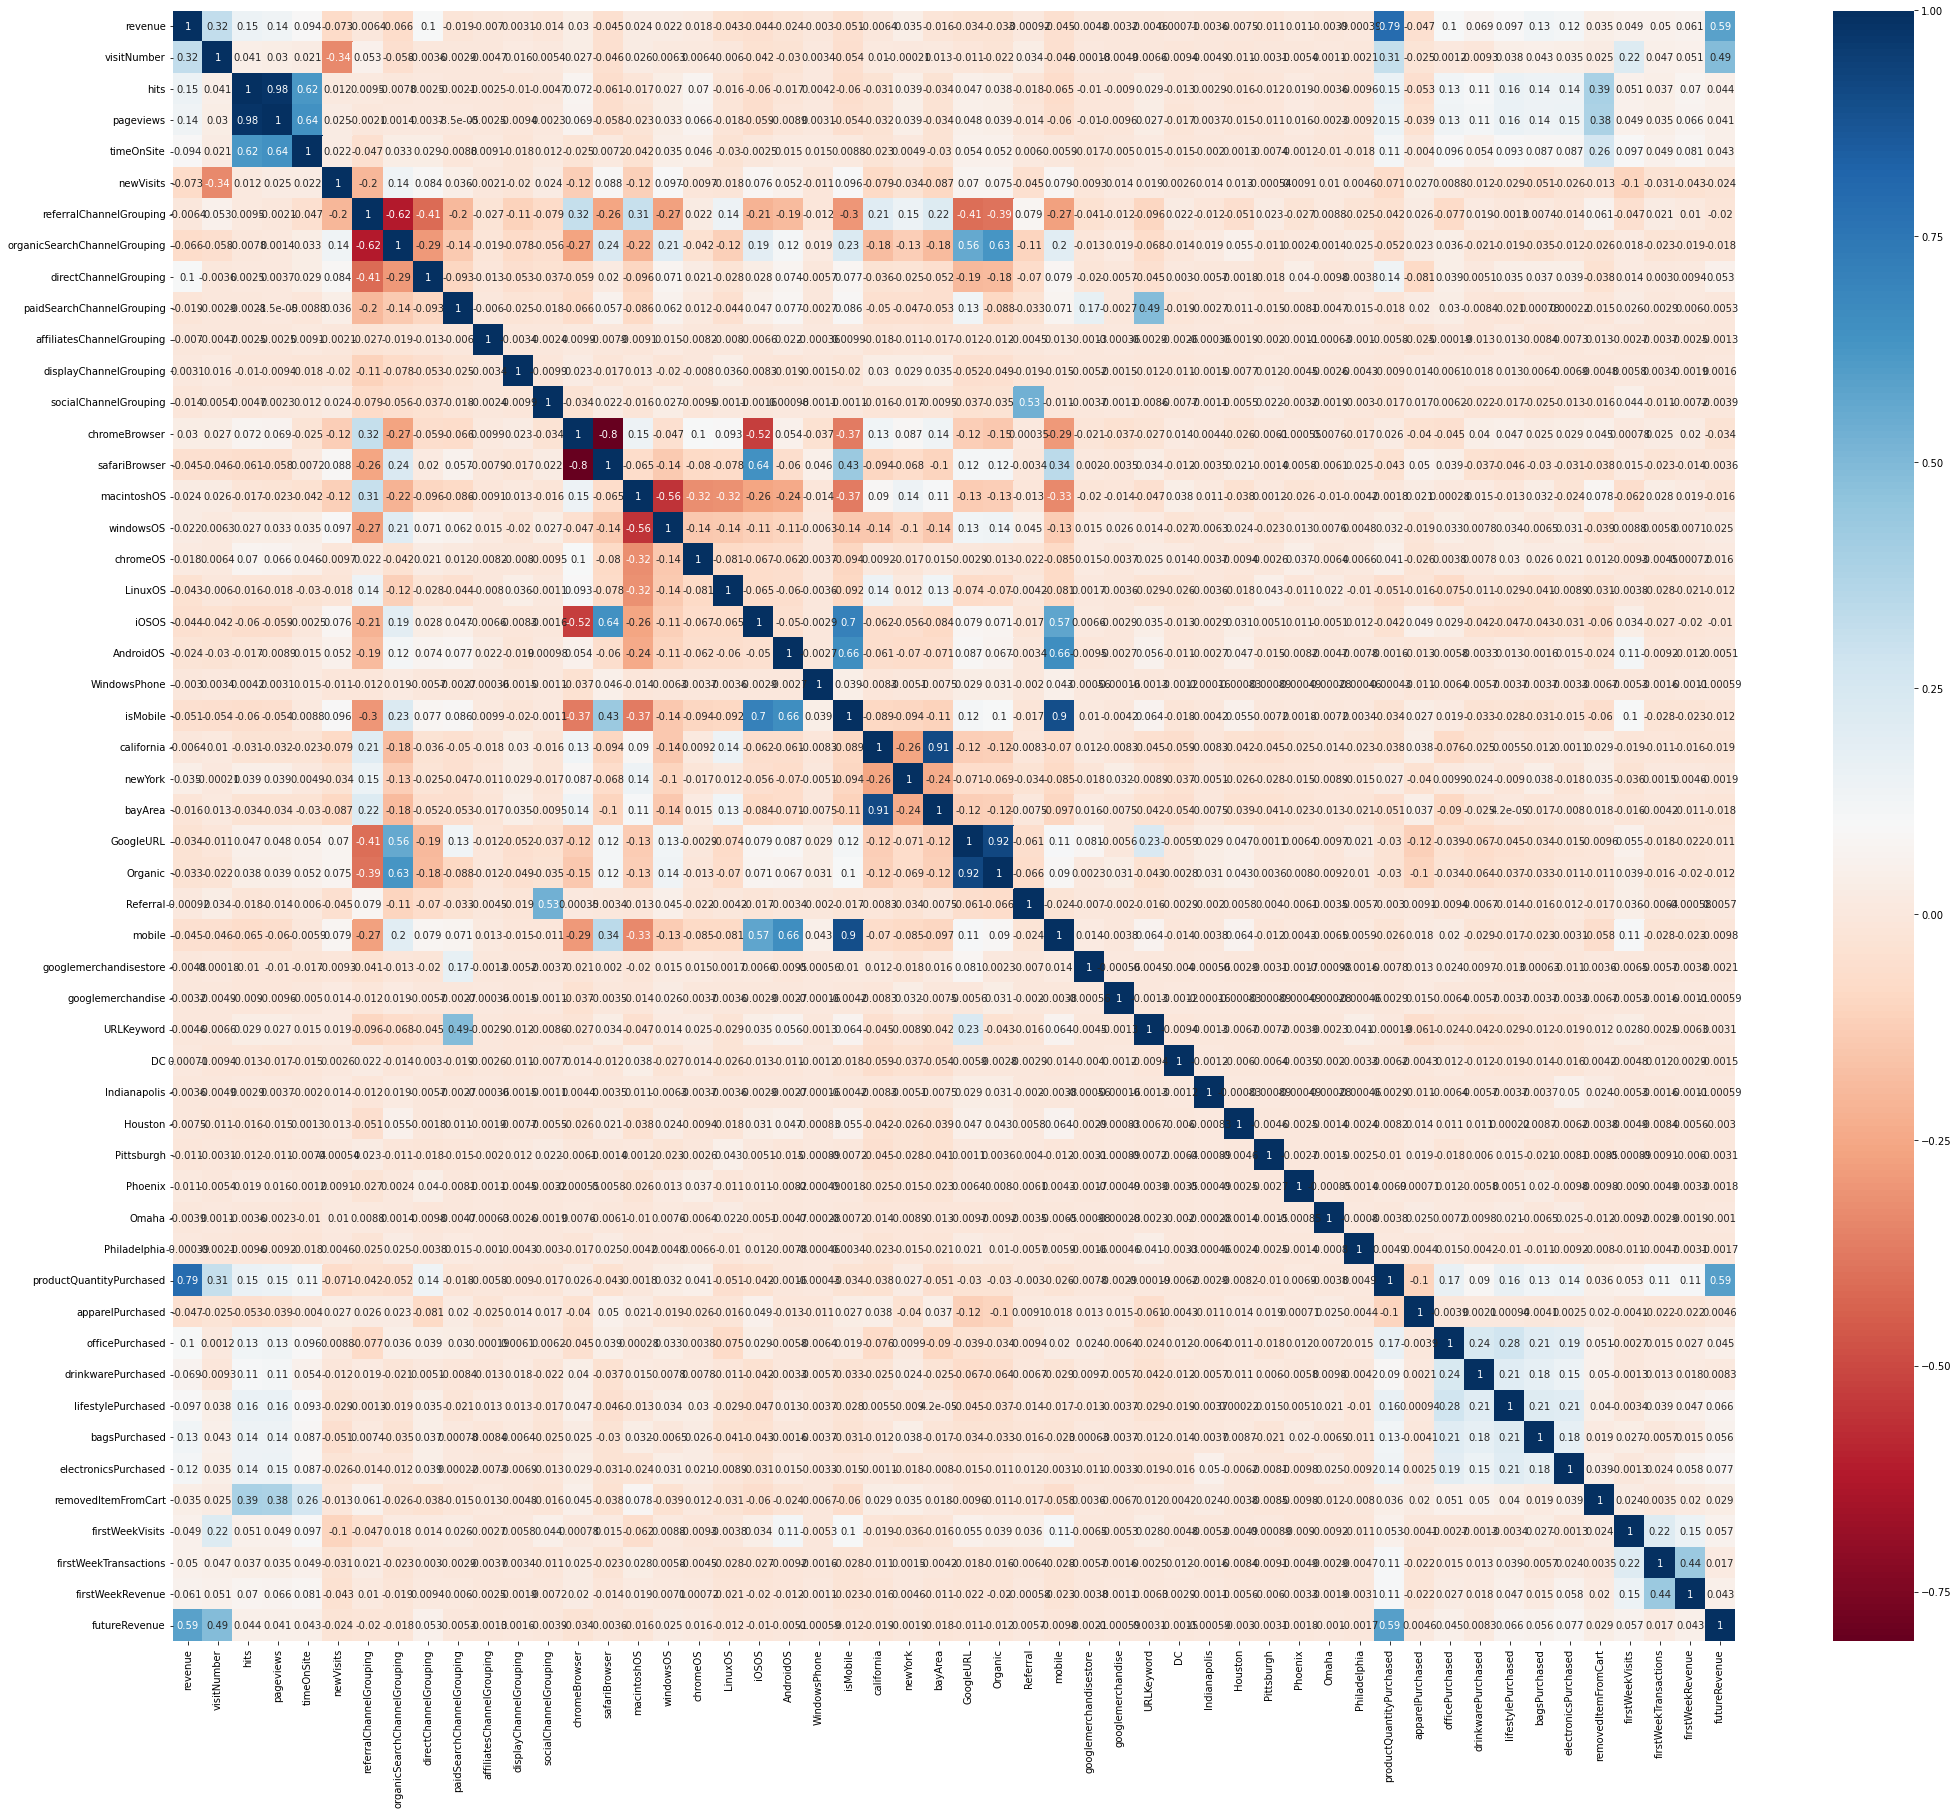

In [ ]:
#Showing all variables' correlation in heatmap
plt.figure(figsize=(35,30))
sns.heatmap(dev_data.corr(), cbar = True, annot = True, cmap='RdBu')

## Exploratory Data Analysis

     |████████████████████████████████| 15.1 MB 7.9 MB/s 


                                             |          | [  0%]   00:00 -> (? left)

Report Advertising.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



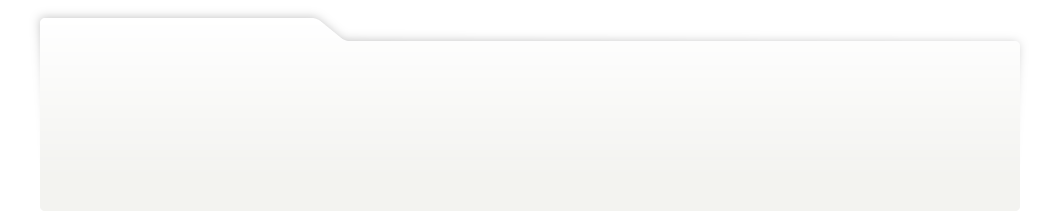
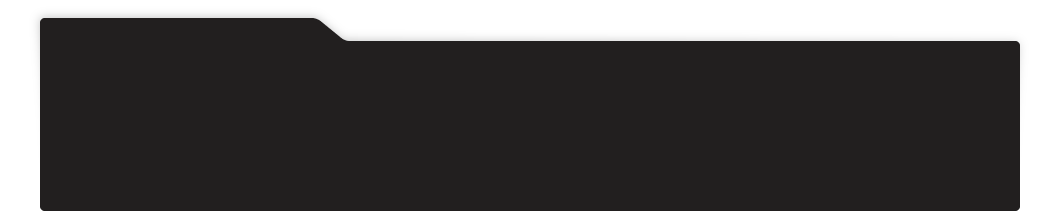
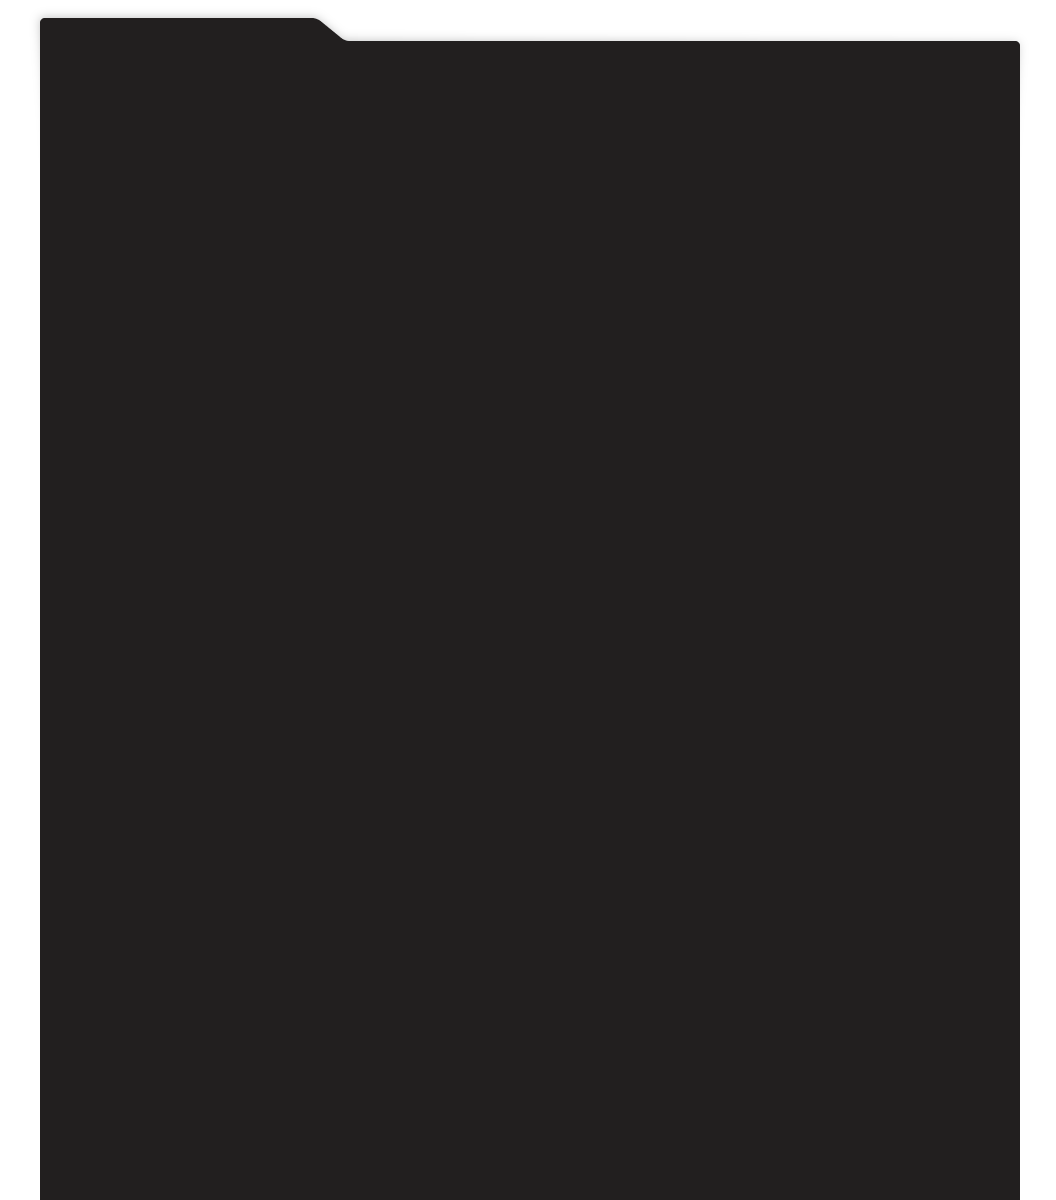
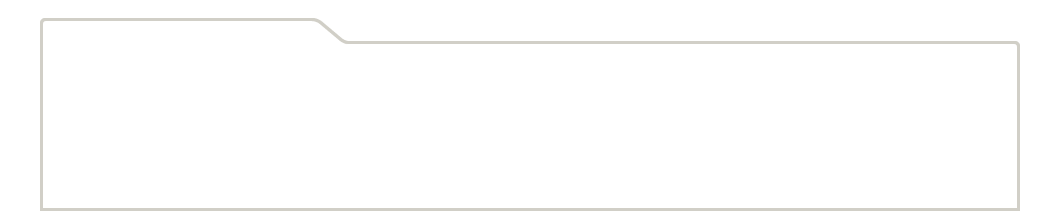
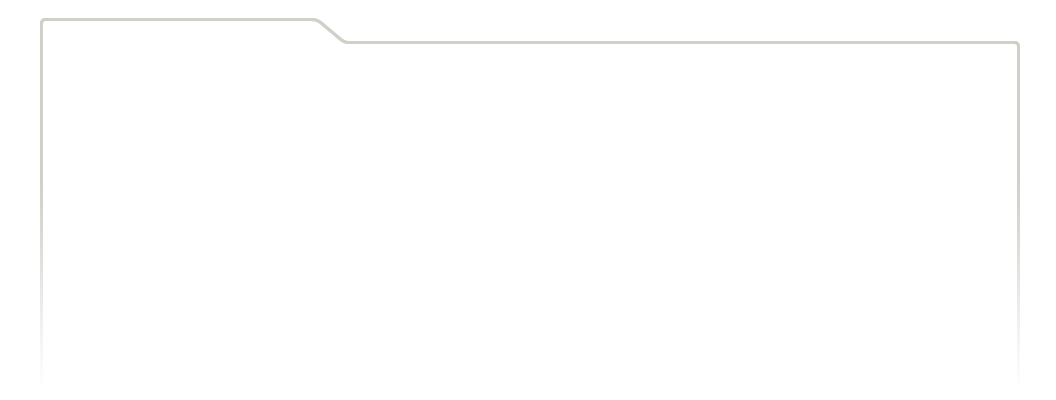
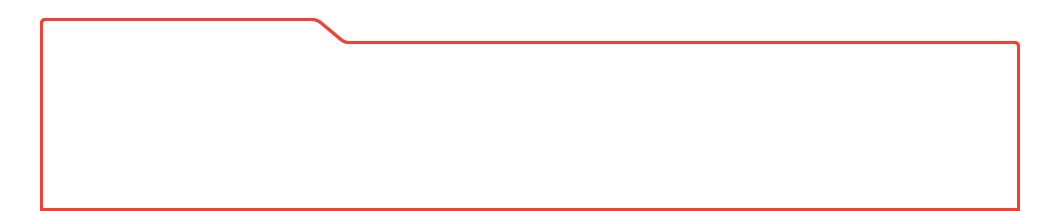
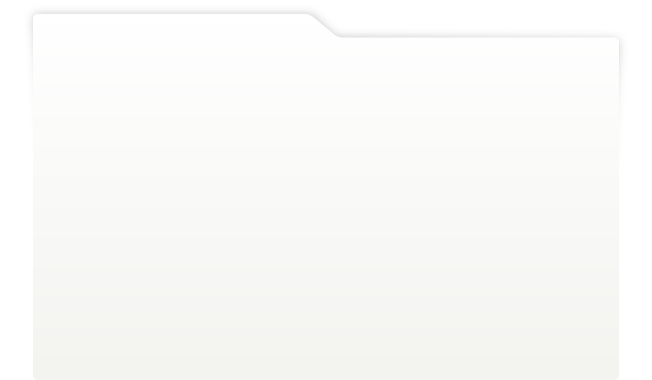
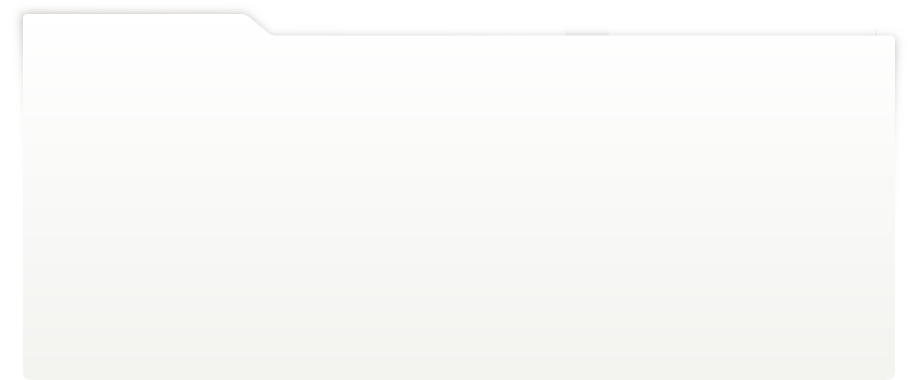
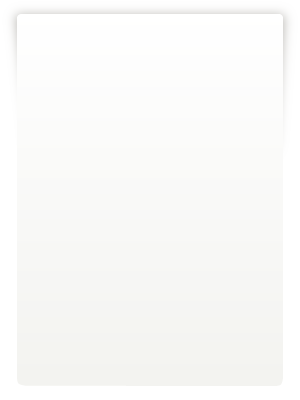
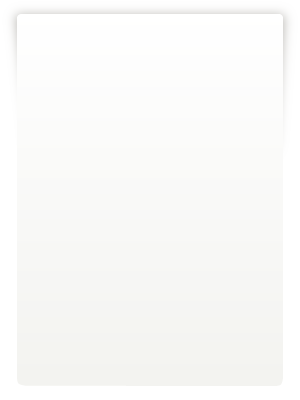
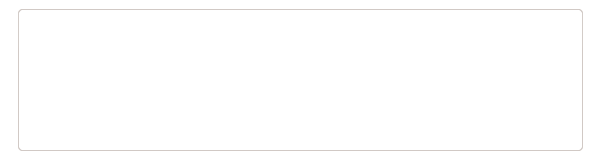
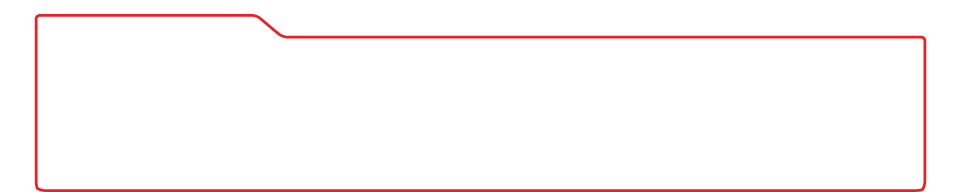
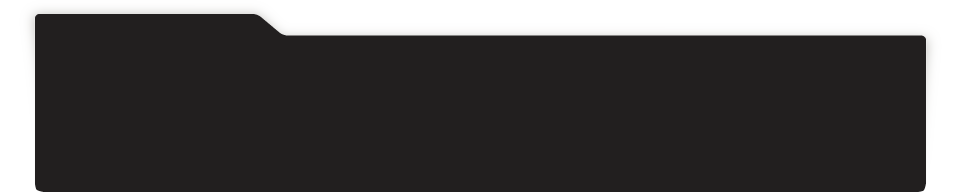
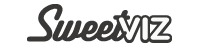
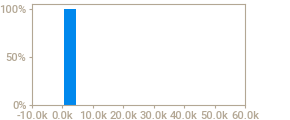
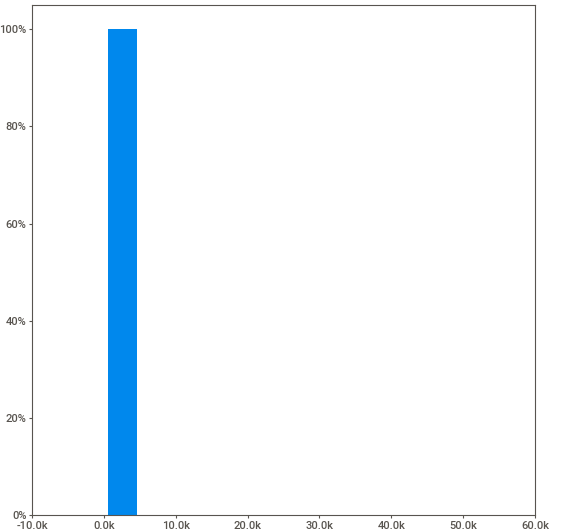
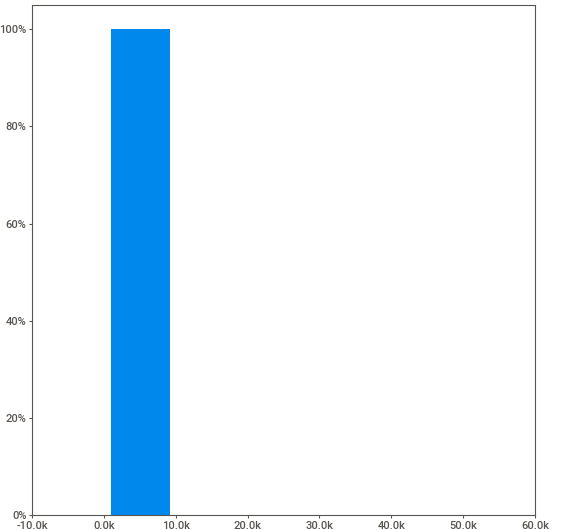
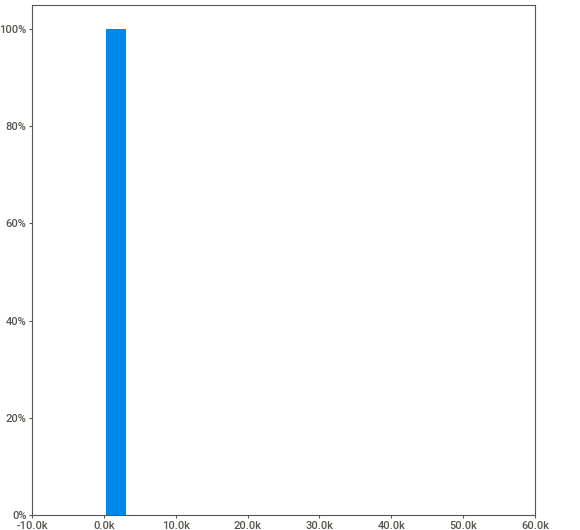
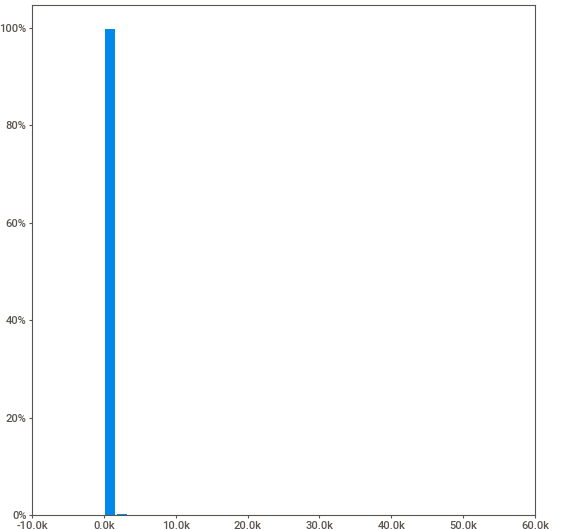
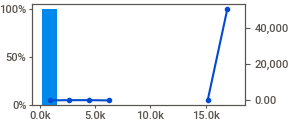
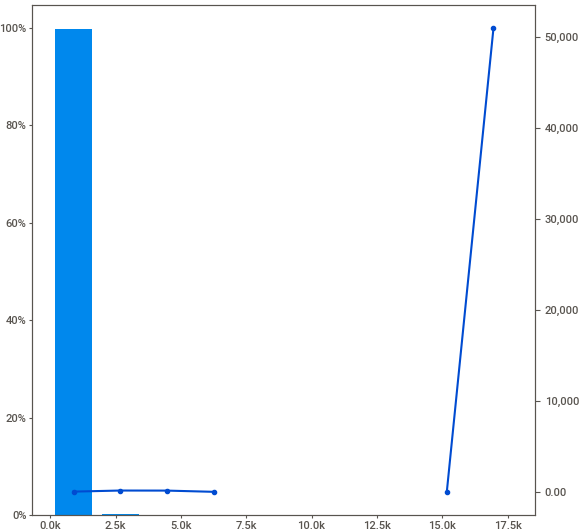
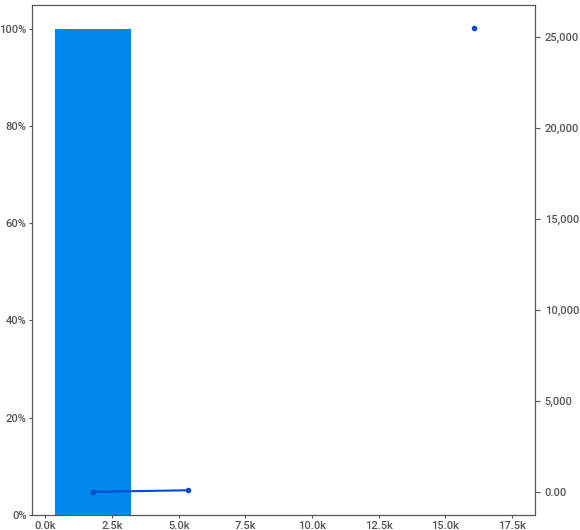
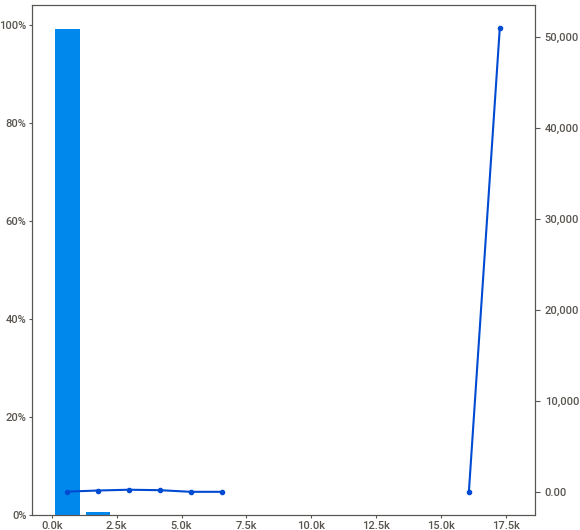
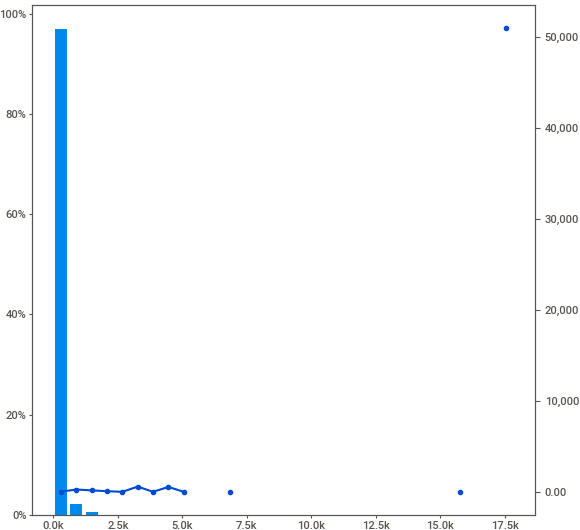
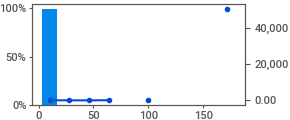
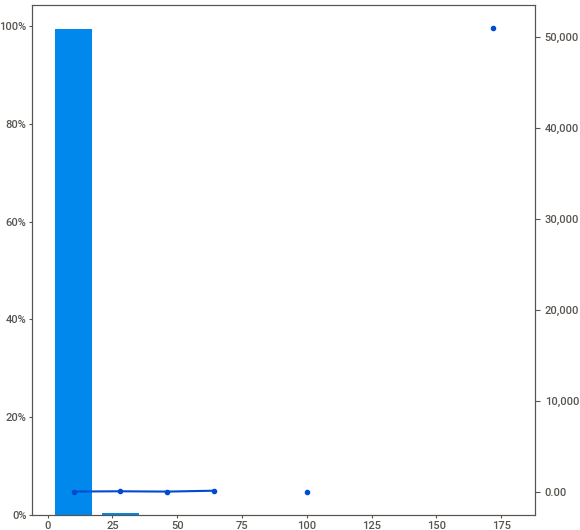
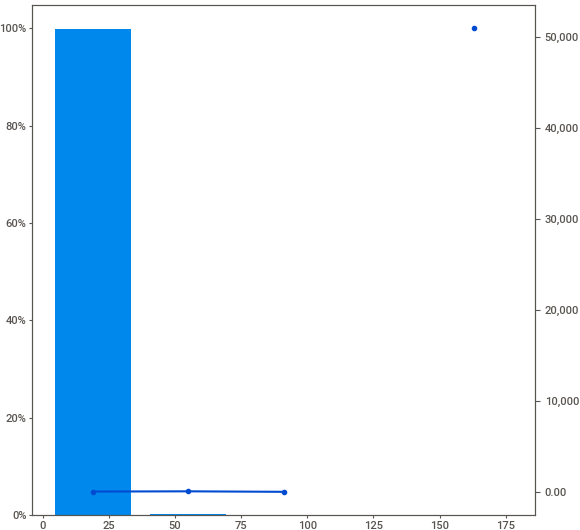
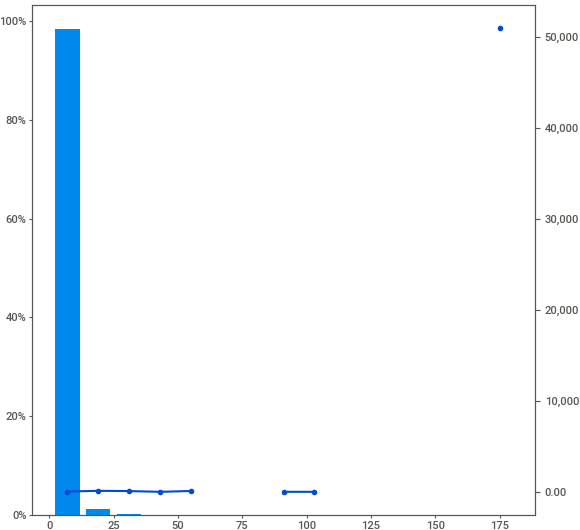
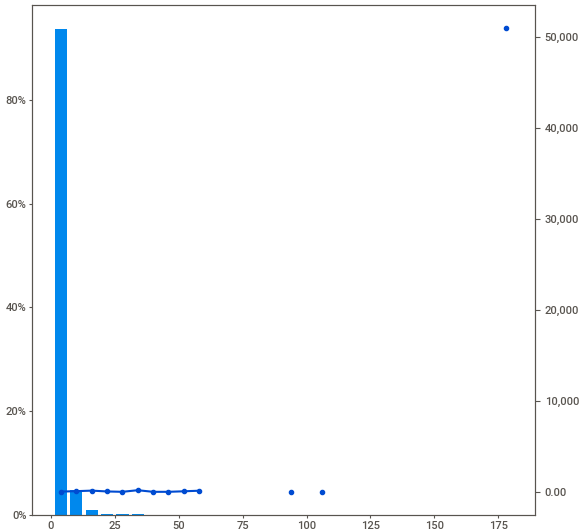
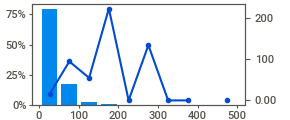
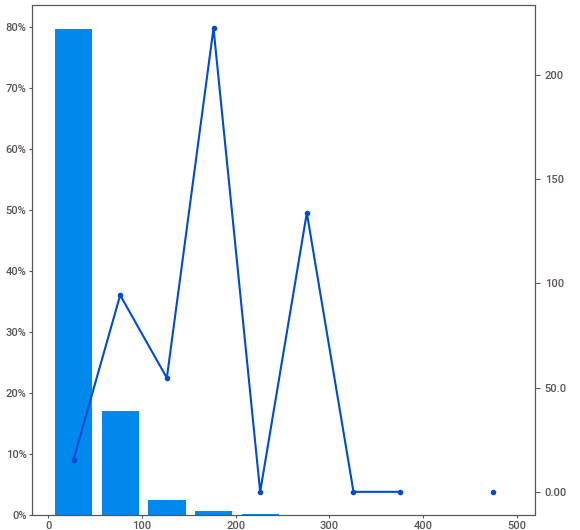
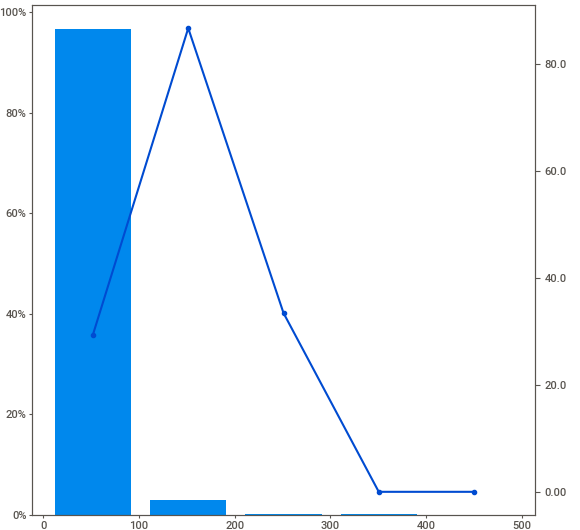
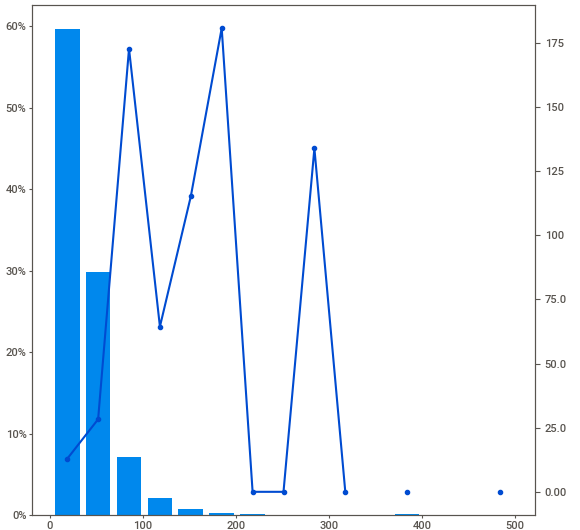
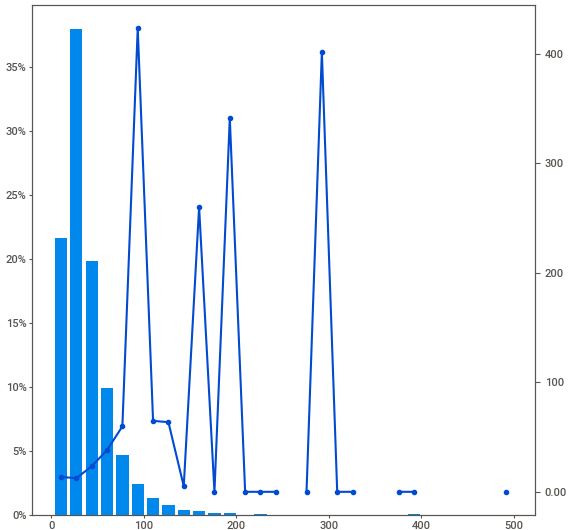
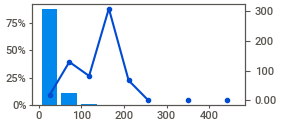
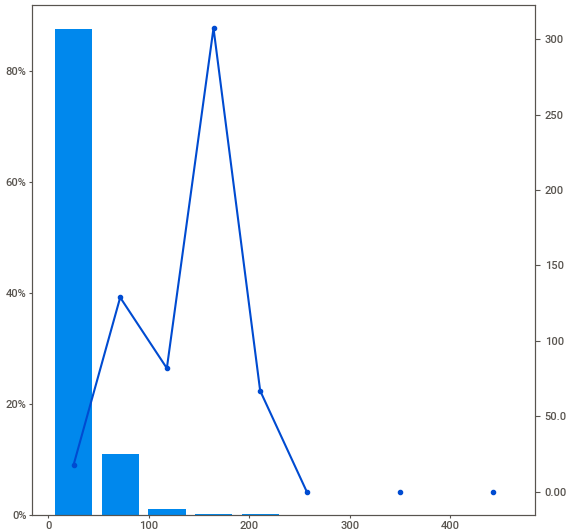
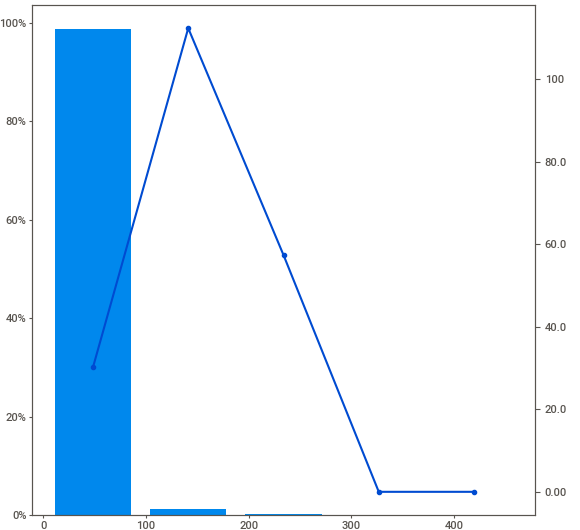
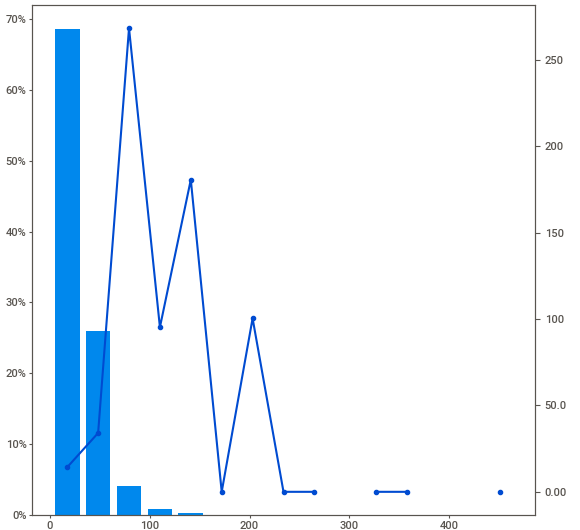
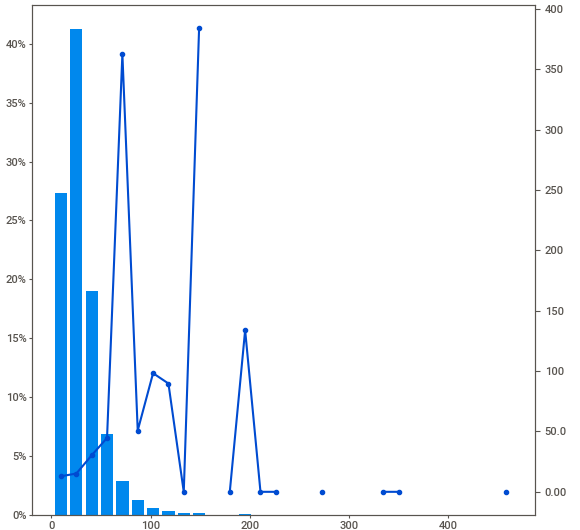
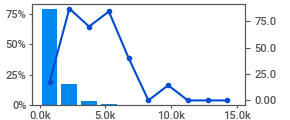
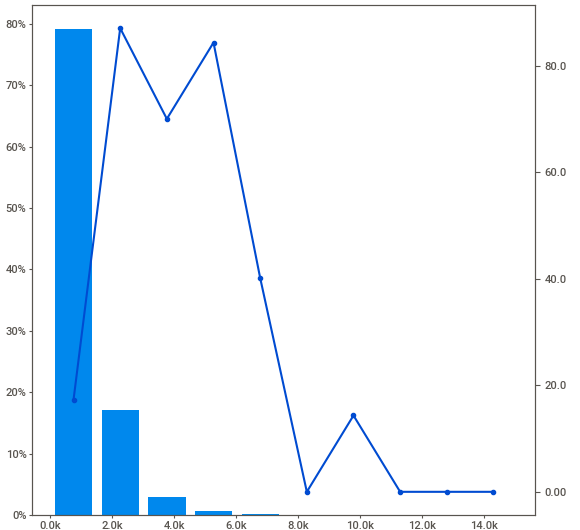
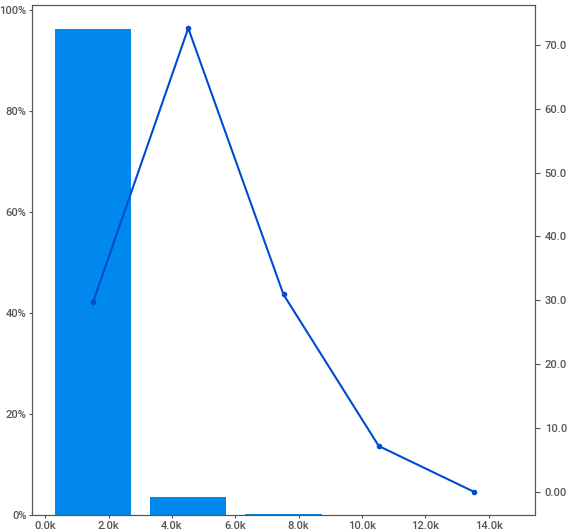
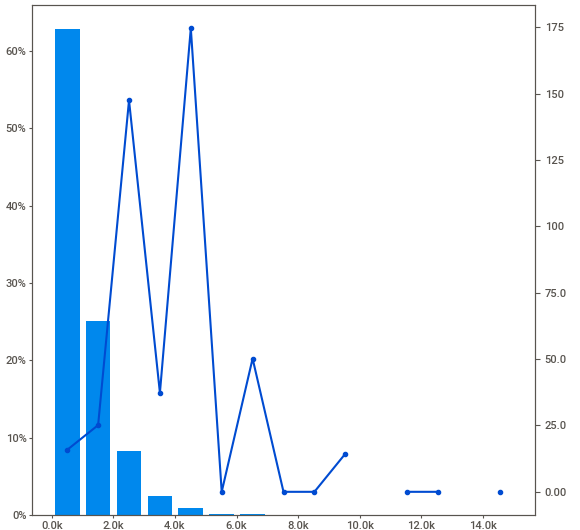
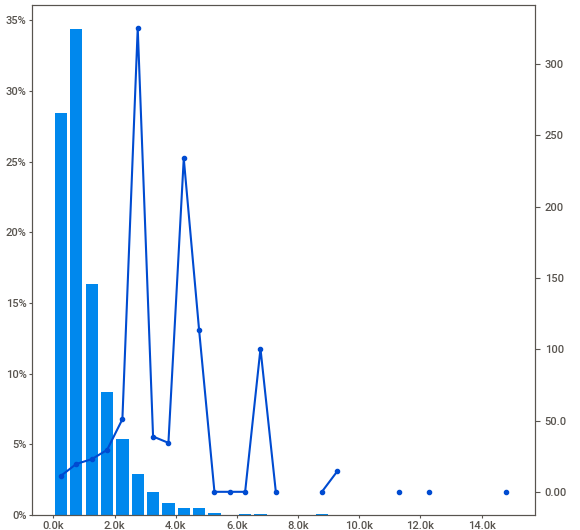
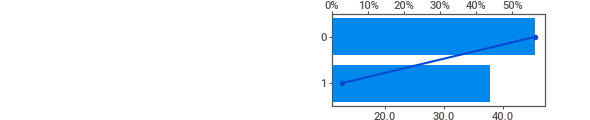
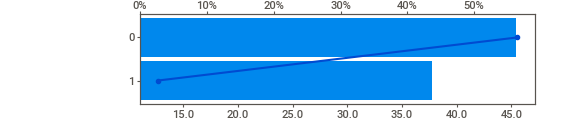
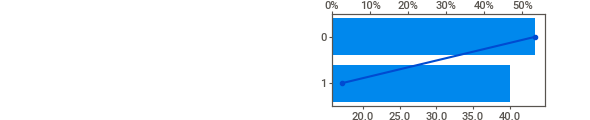
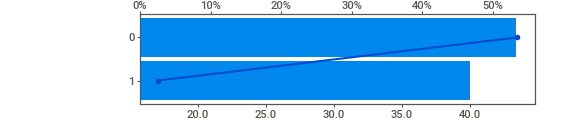
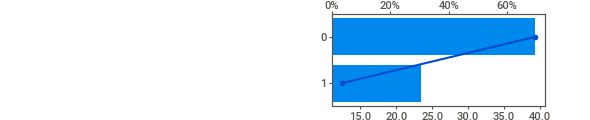
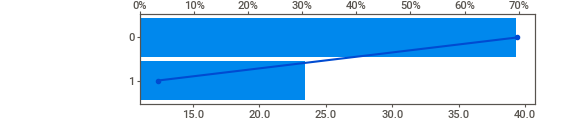
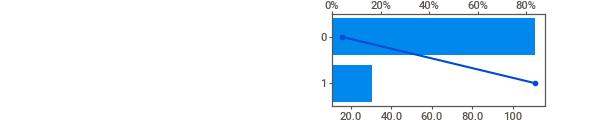
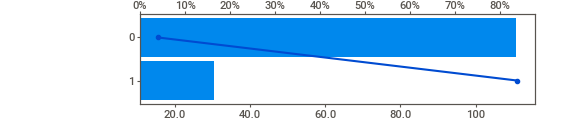
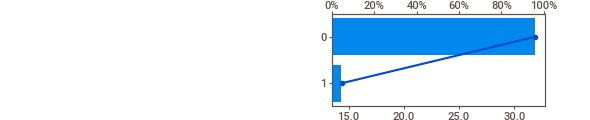
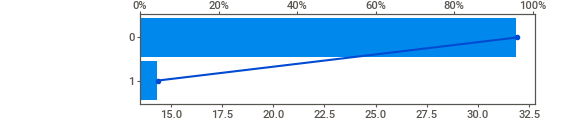
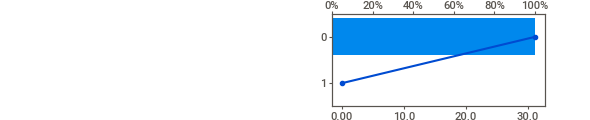
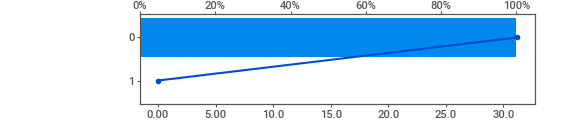
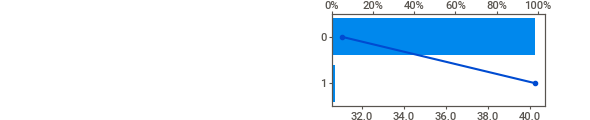
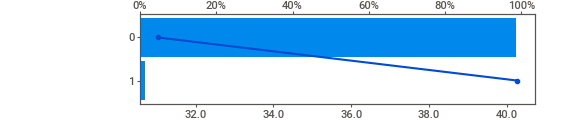
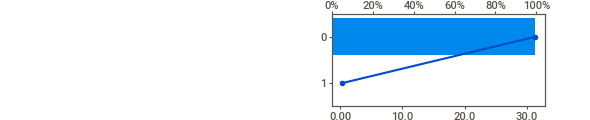
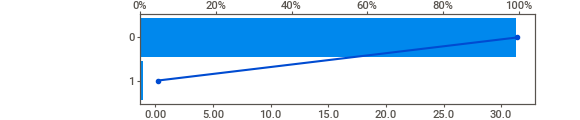
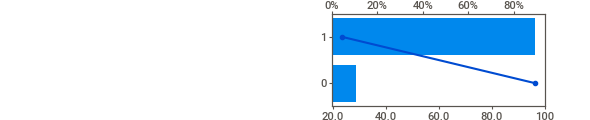
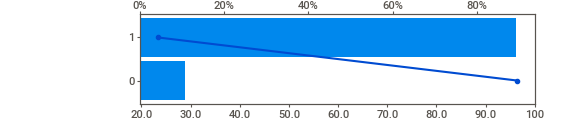
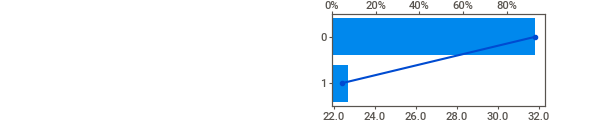
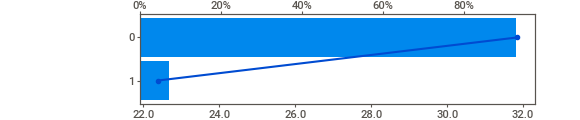
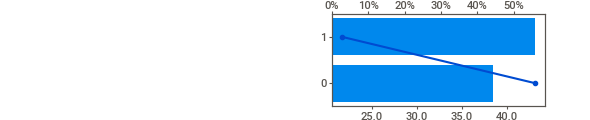
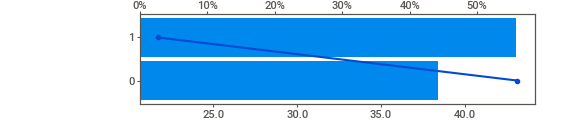
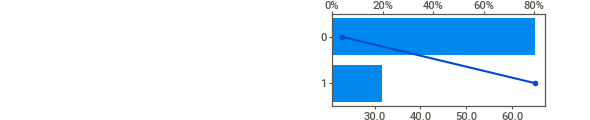
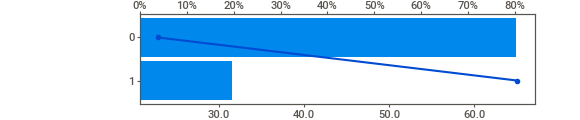
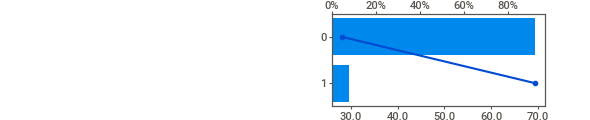
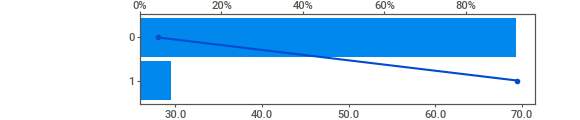
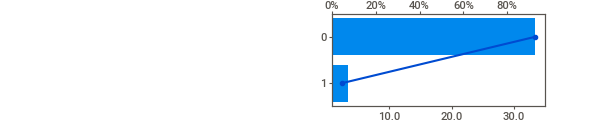
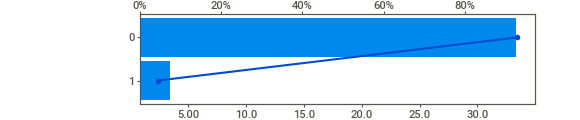
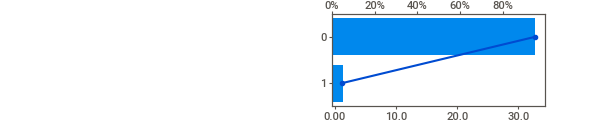
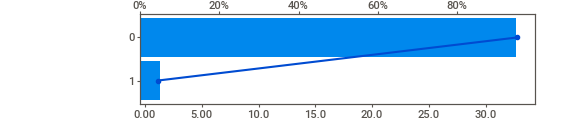
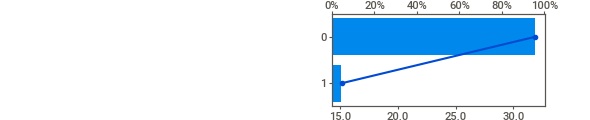
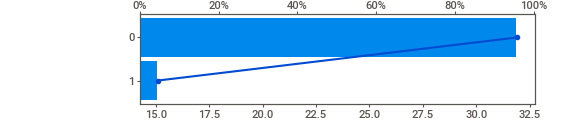
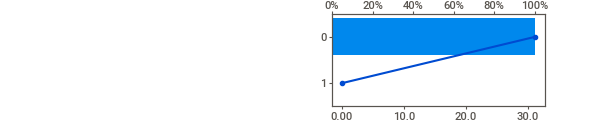
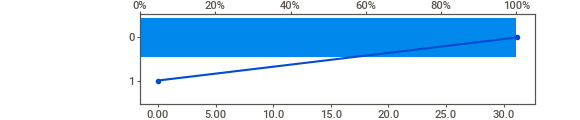
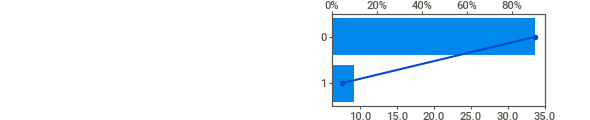
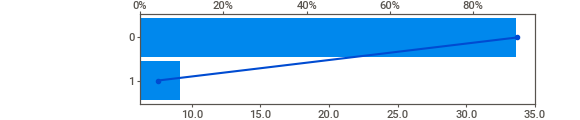
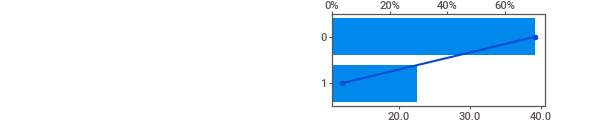
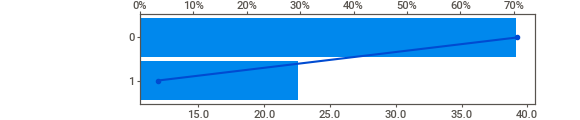
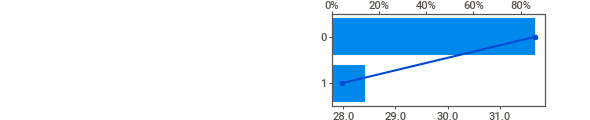
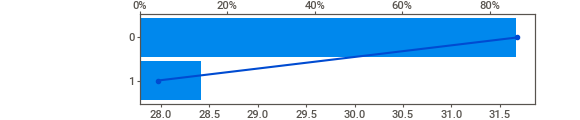
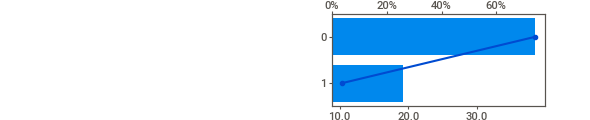
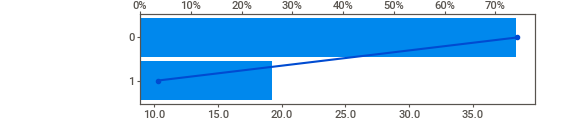
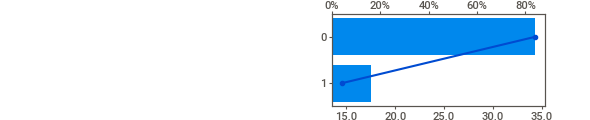
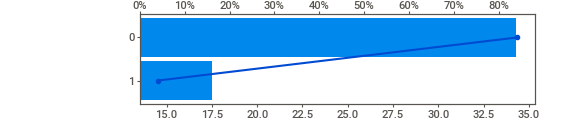
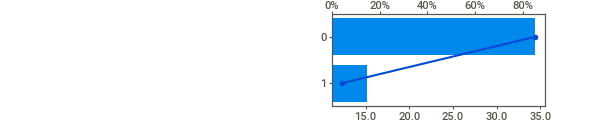
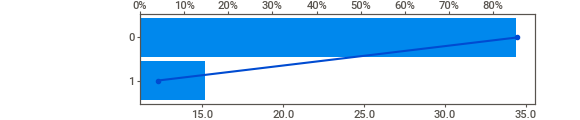
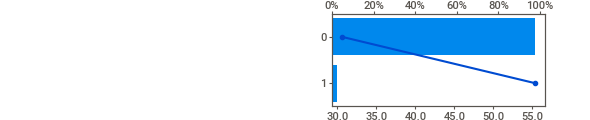
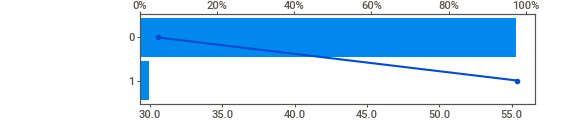
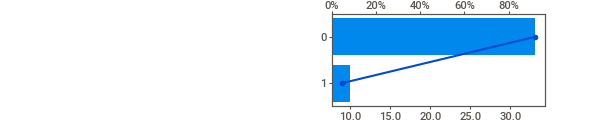
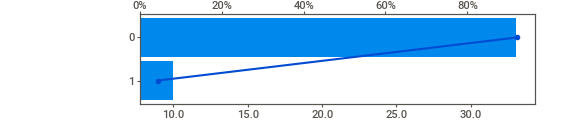
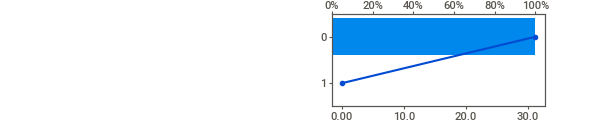
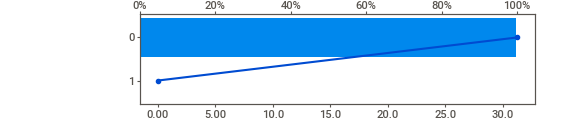
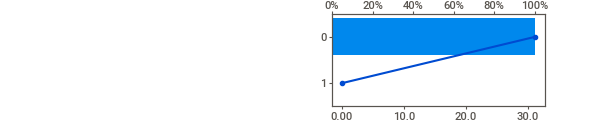
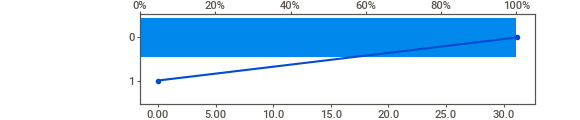
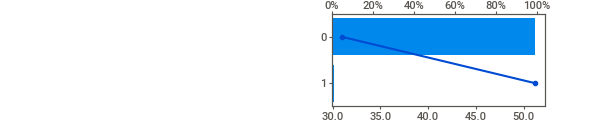
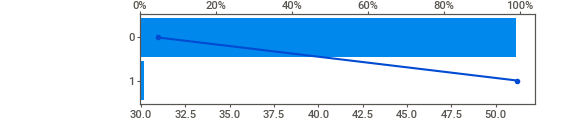
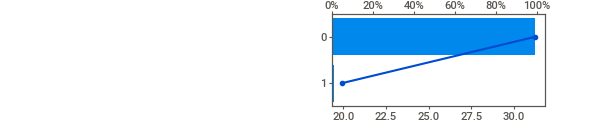
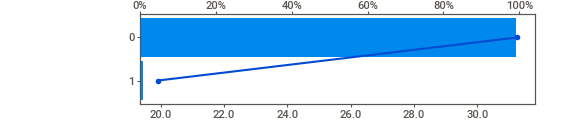
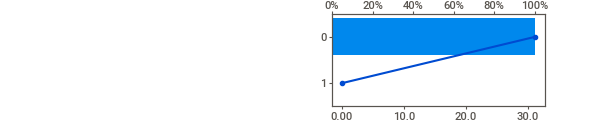
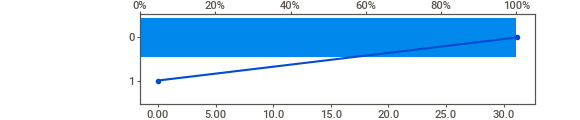
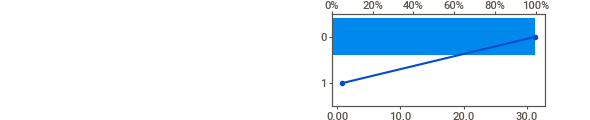
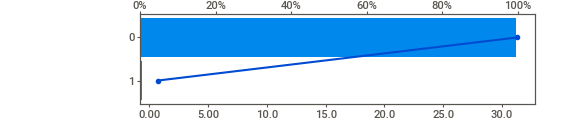
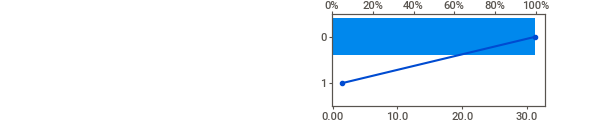
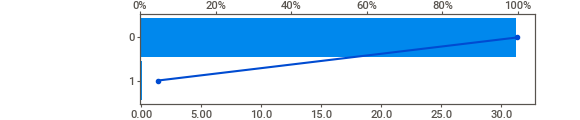
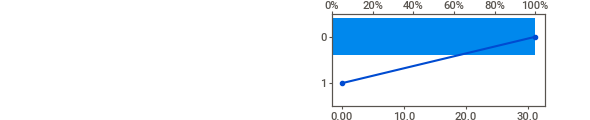
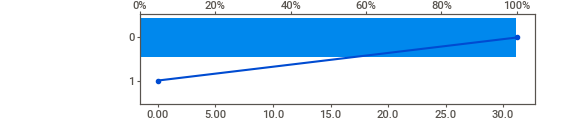
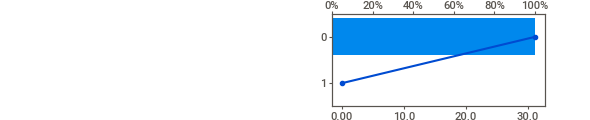
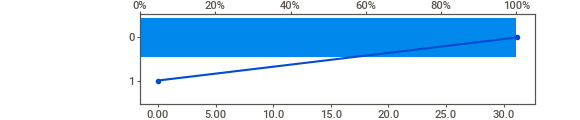
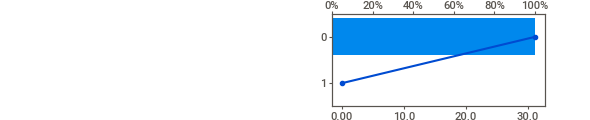
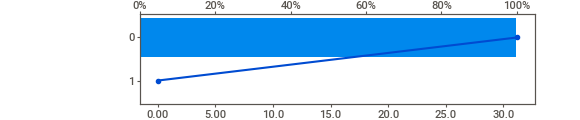
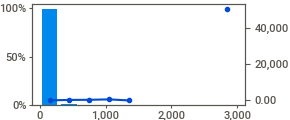
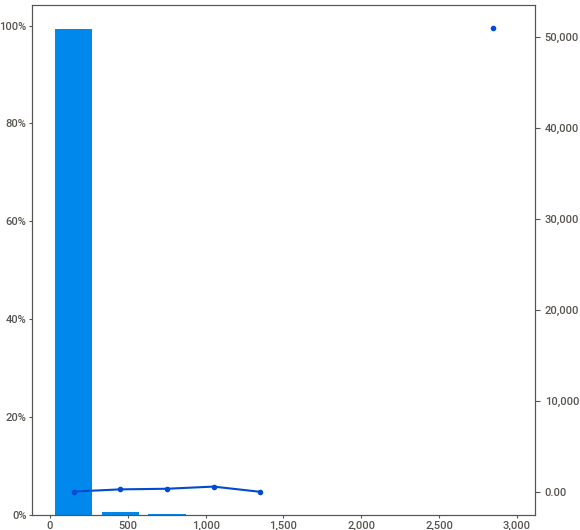
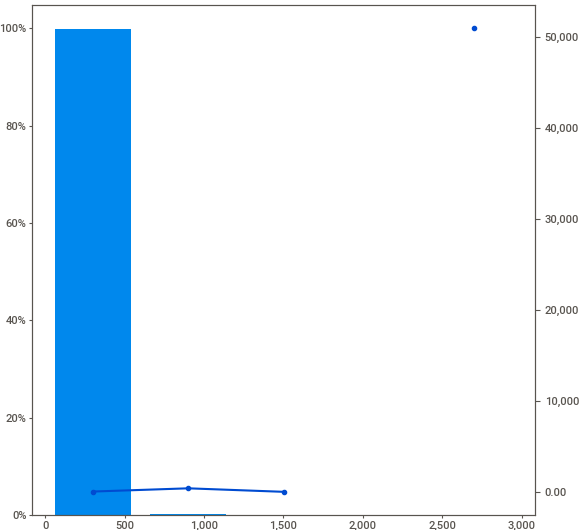
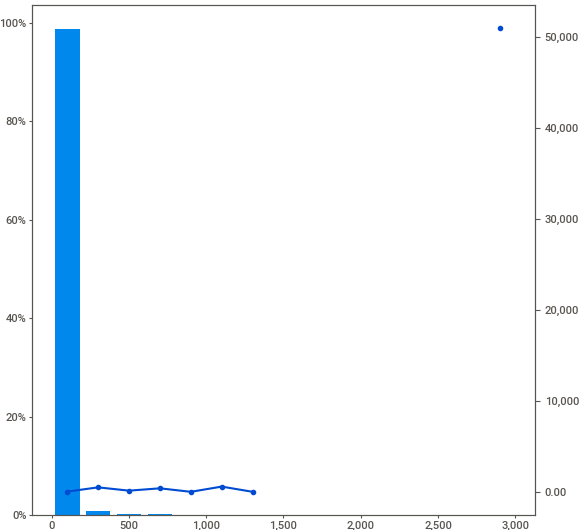
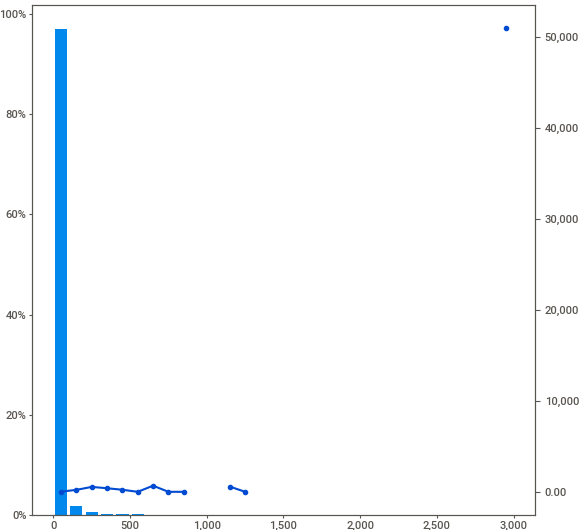
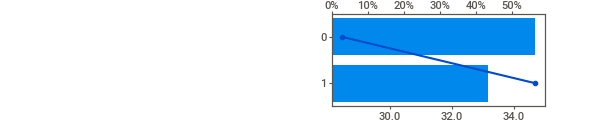
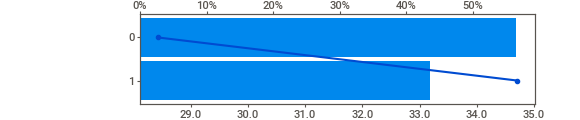
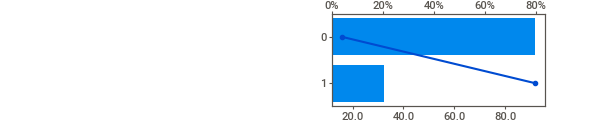
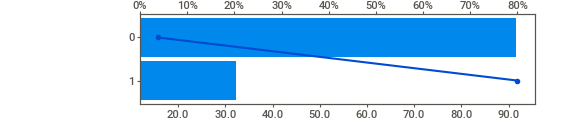
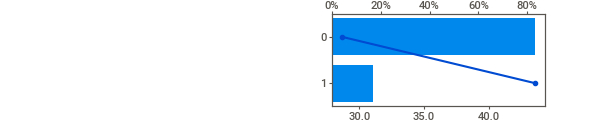
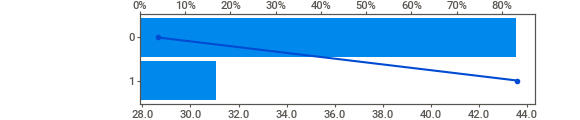
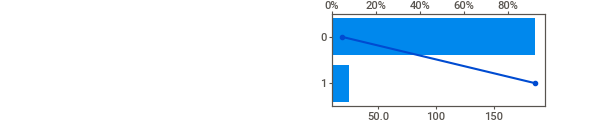
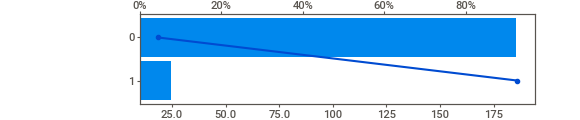
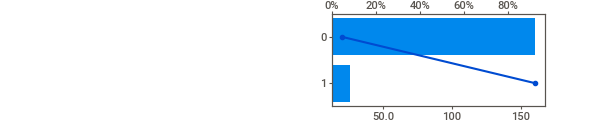
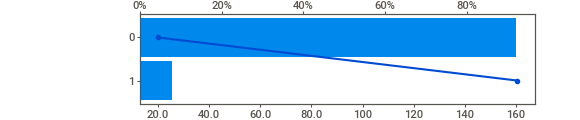
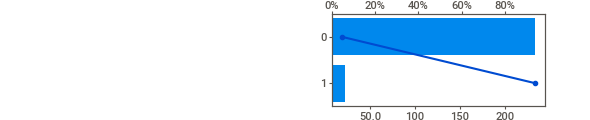
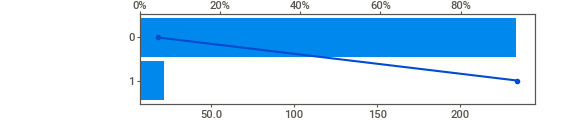
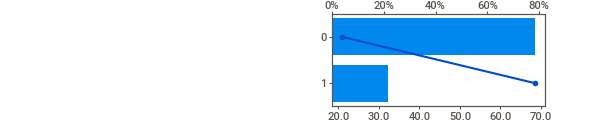
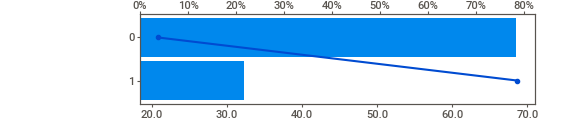
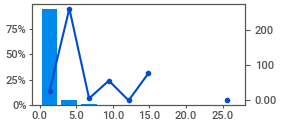
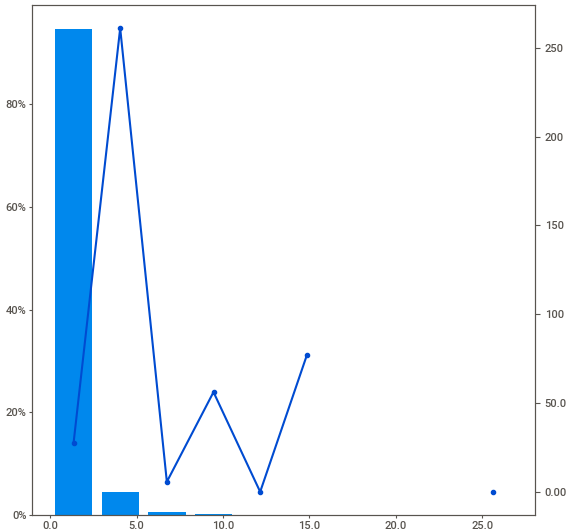
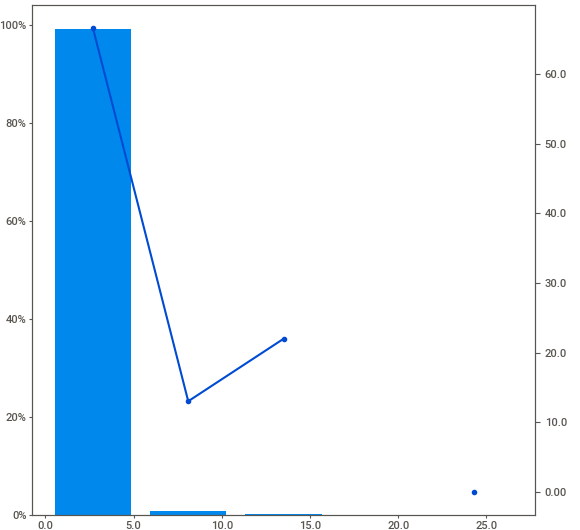
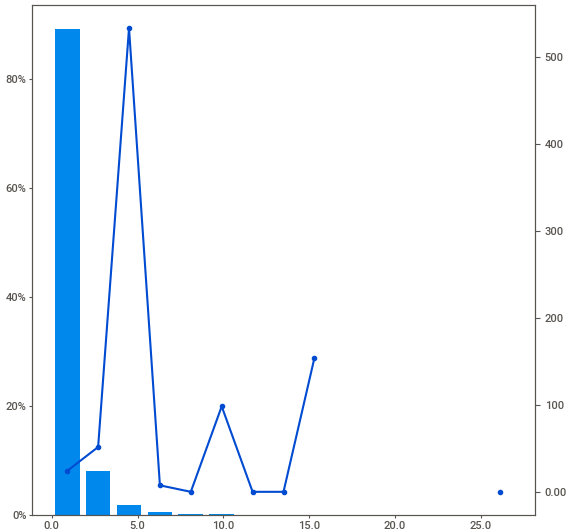
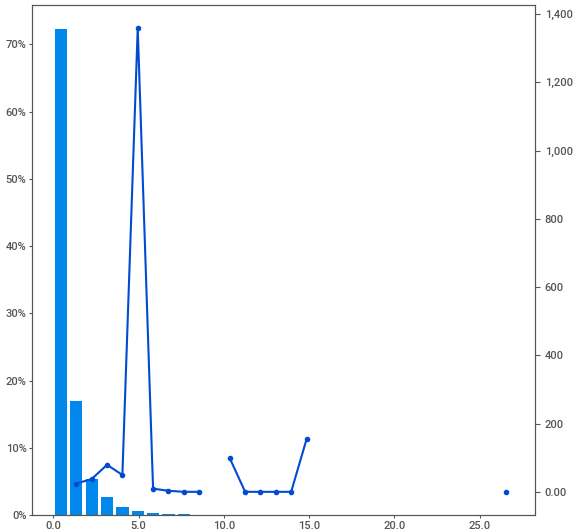
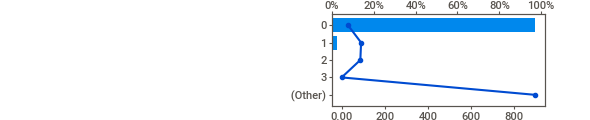
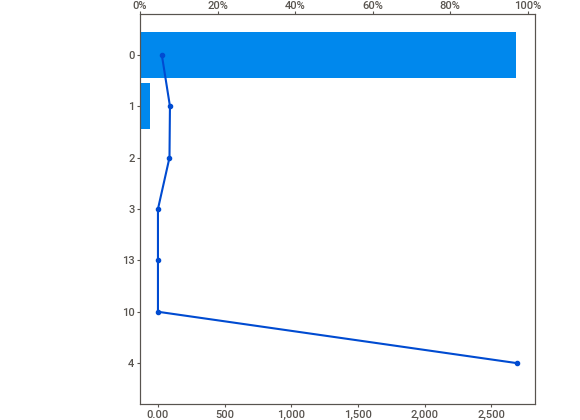
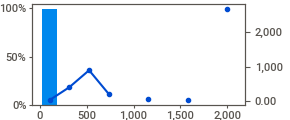
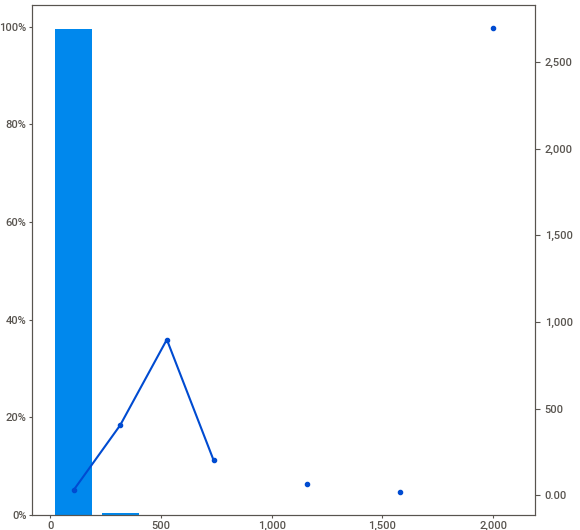
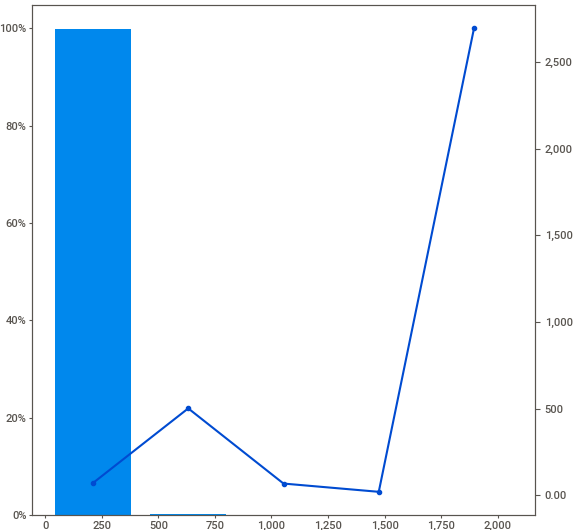
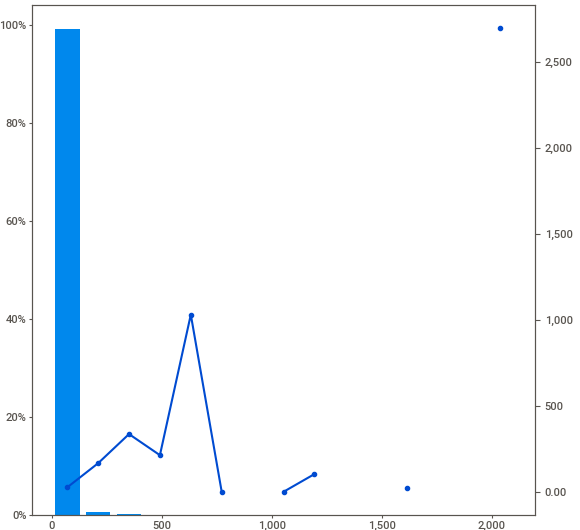
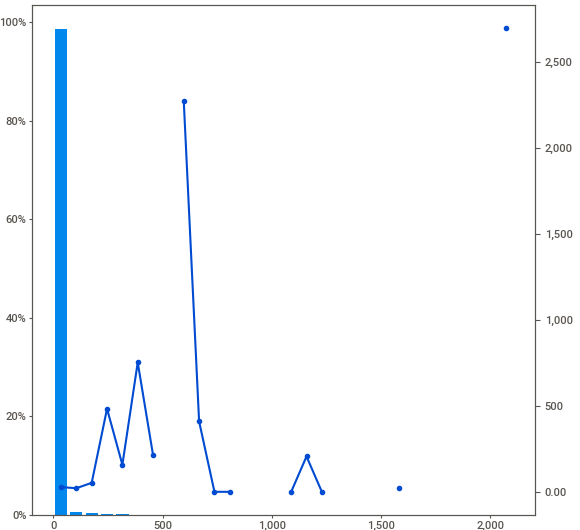
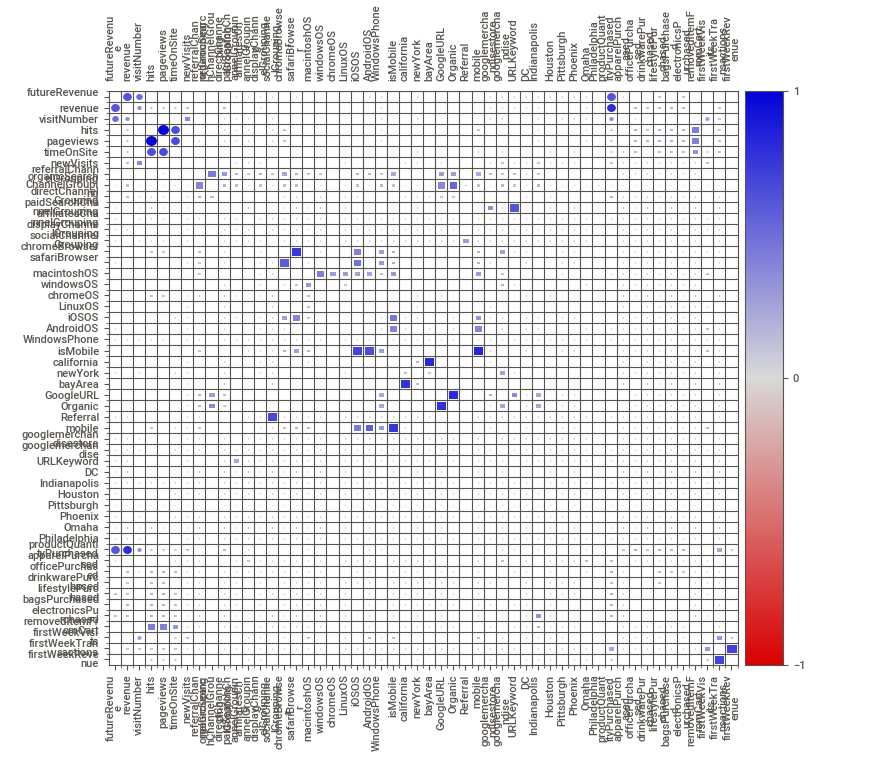
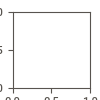

In [ ]:
#Replacing Panda Profile with Sweetviz to visualize data
!pip install sweetviz

import sweetviz as sv

eda_data = dev_data.drop(['fullVisitorId', 'firstPurchaseSessionTime'], axis=1) # Exclude fullVisitorId and firstPurchaseSessionTime from EDA
eda_data = eda_data.reset_index(drop=True)
eda_report=sv.analyze(eda_data, target_feat='futureRevenue' ,pairwise_analysis='on')
eda_report.show_html('Advertising.html')
import IPython
IPython.display.HTML('Advertising.html')

Based on the exploratory data analysis above, a few things are evident.
- There are outliers present with respect to both the dependent and independent variables. Specifically, there are a few high values for futureRevenue, revenue, visitNumber and productQuantityPurchased. For simplicity, I will drop records containing these outliers.
- Unfortunately it doesn't look like there are any high correlations between the futureRevenue and other variables. This will make modeling challenging.
- 93% of futureRevenue values are 0. This will likely present a challenge for modeling. 

                                             |          | [  0%]   00:00 -> (? left)

Report Advertising.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



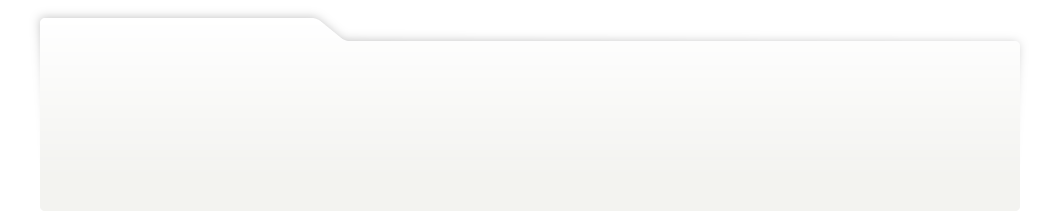
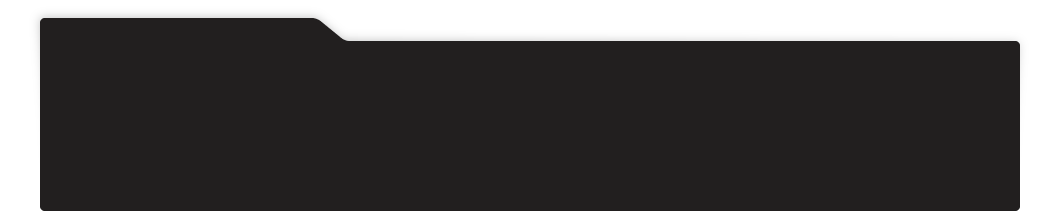
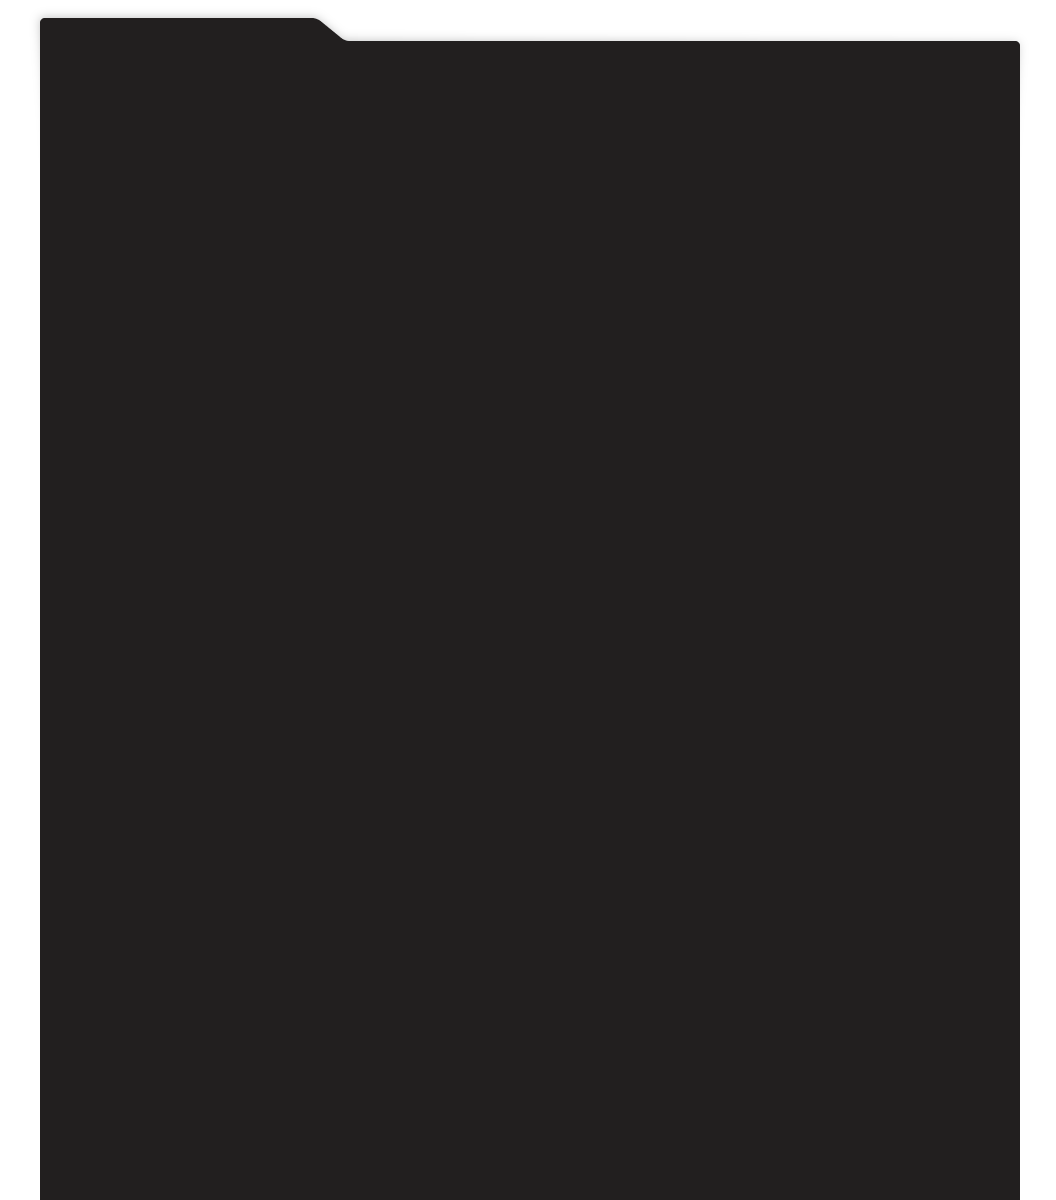
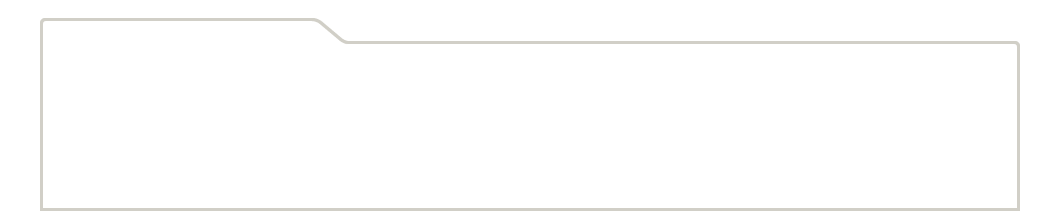
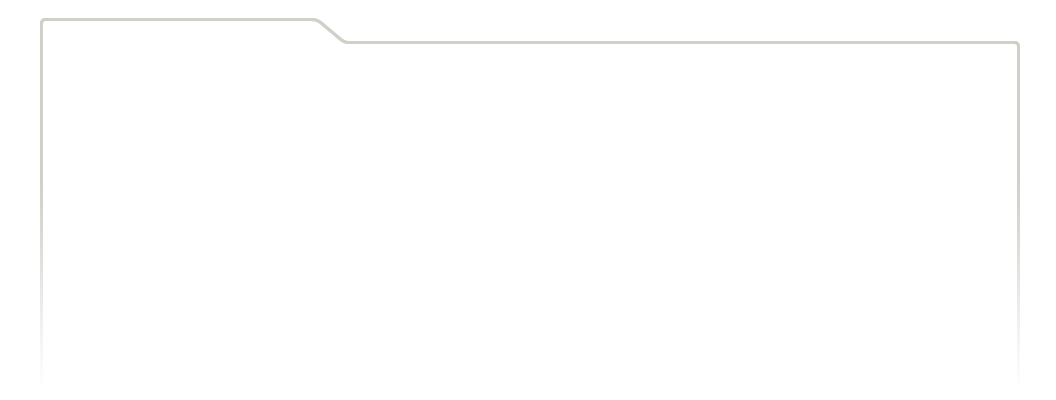
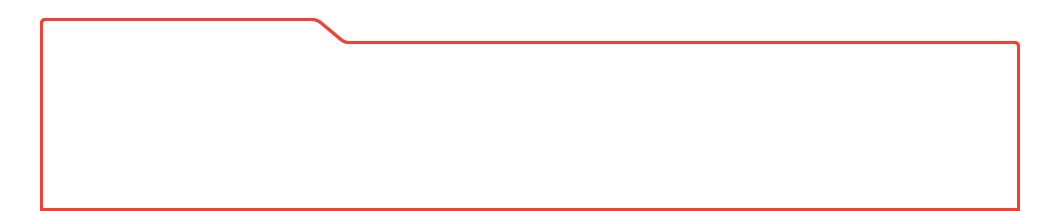
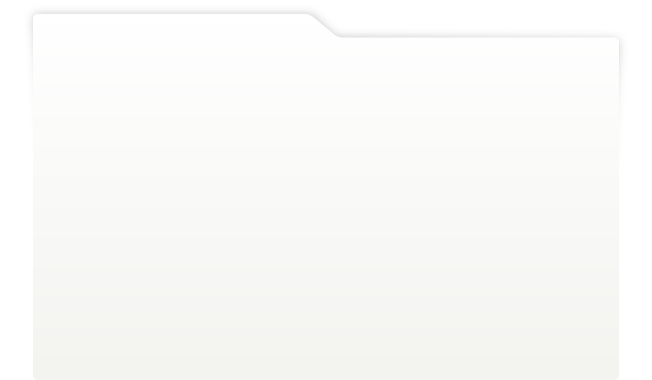
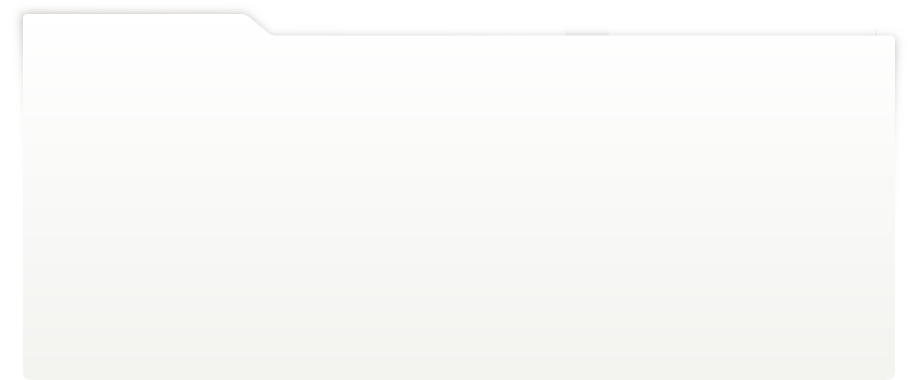
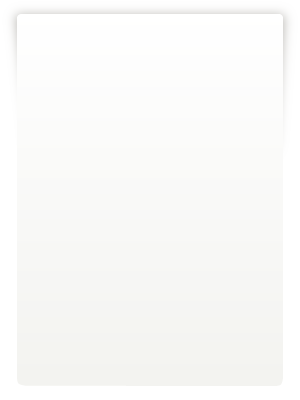
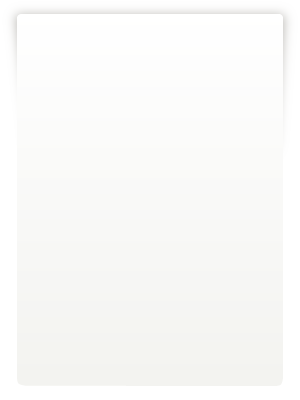
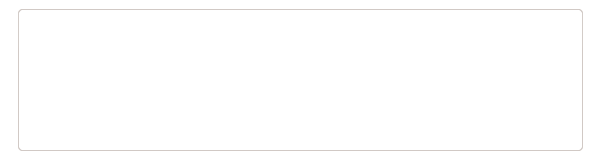
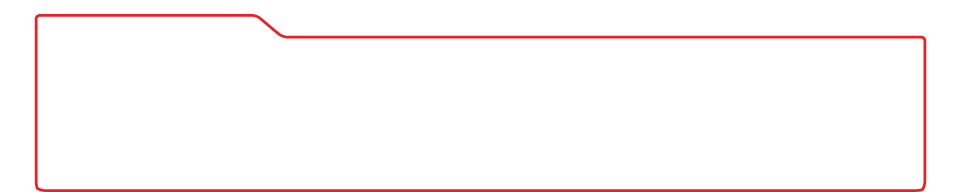
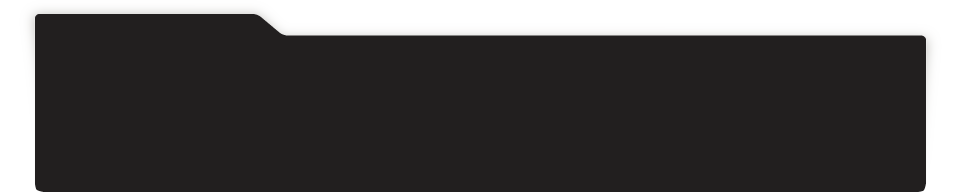
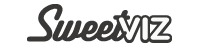
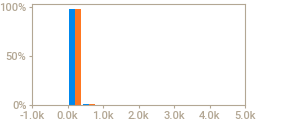
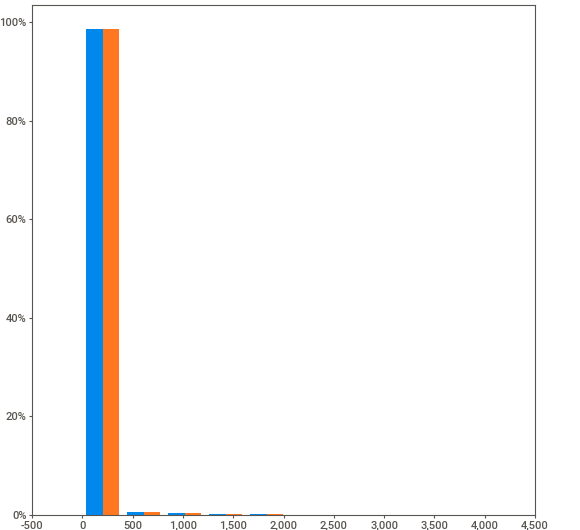
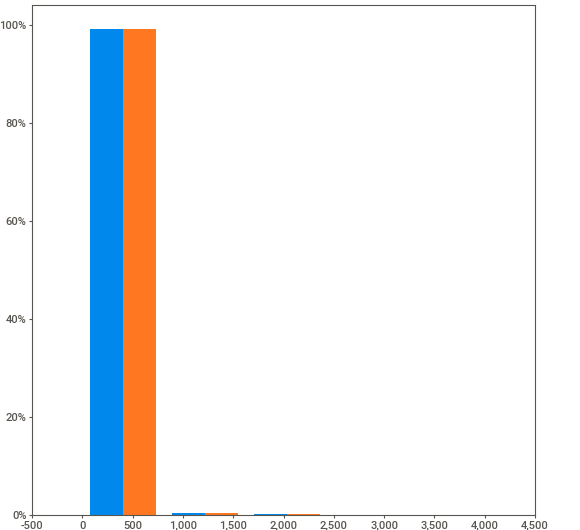
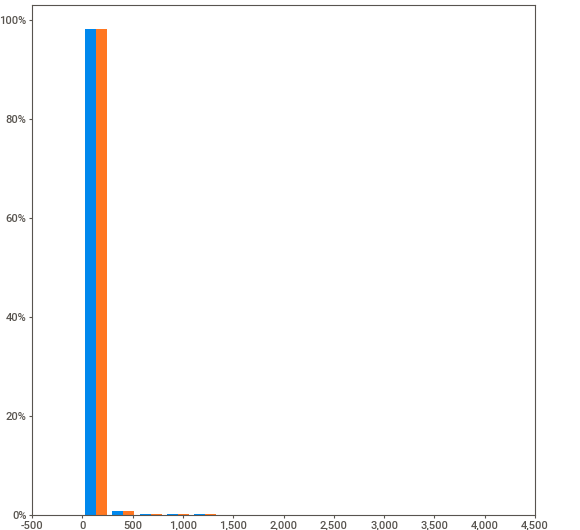
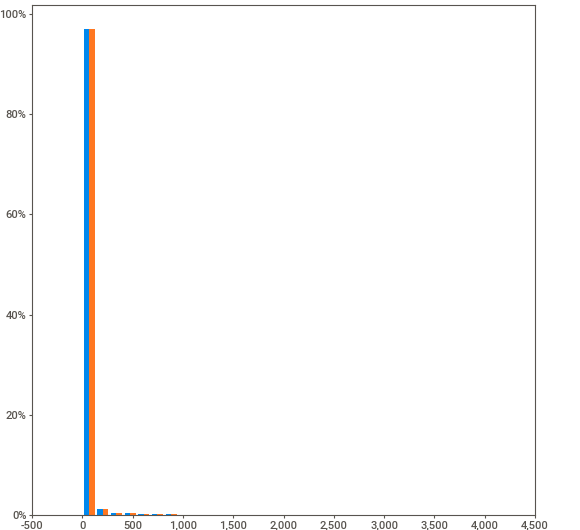
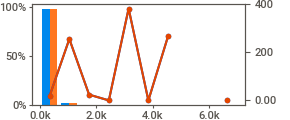
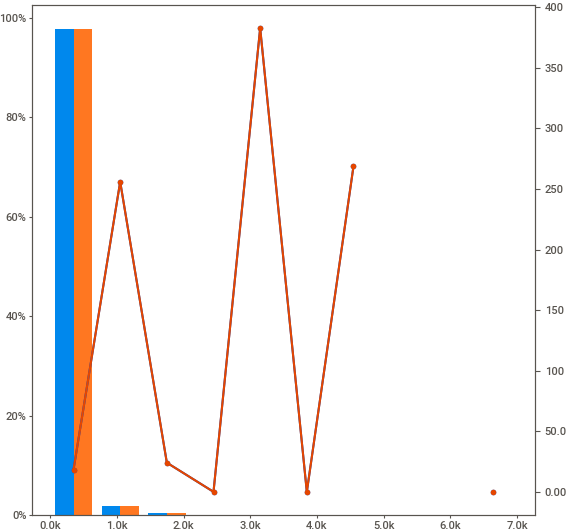
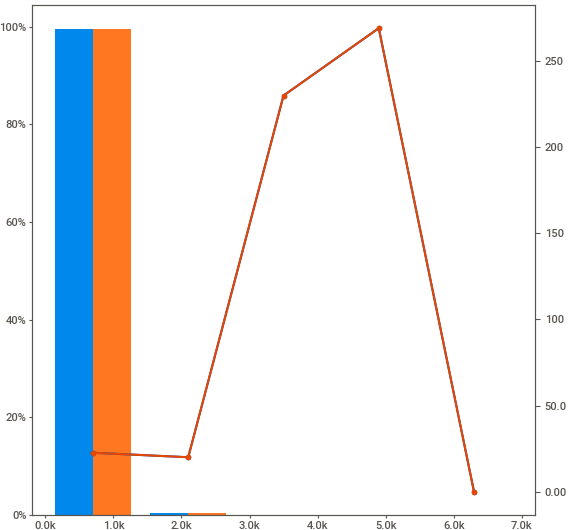
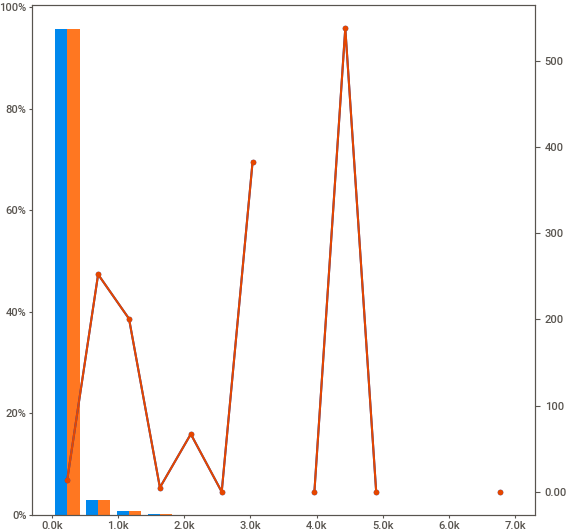
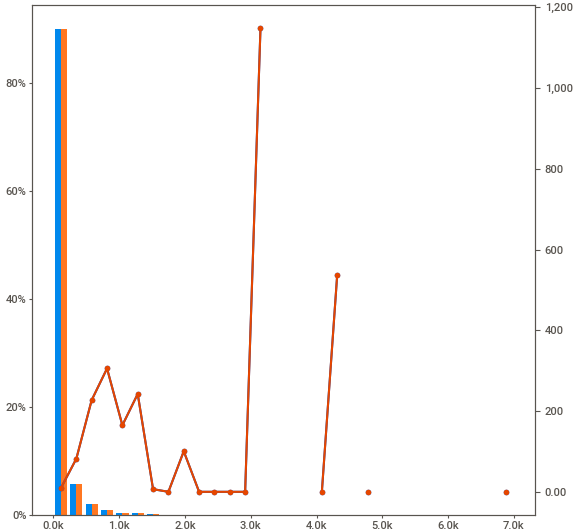
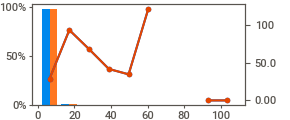
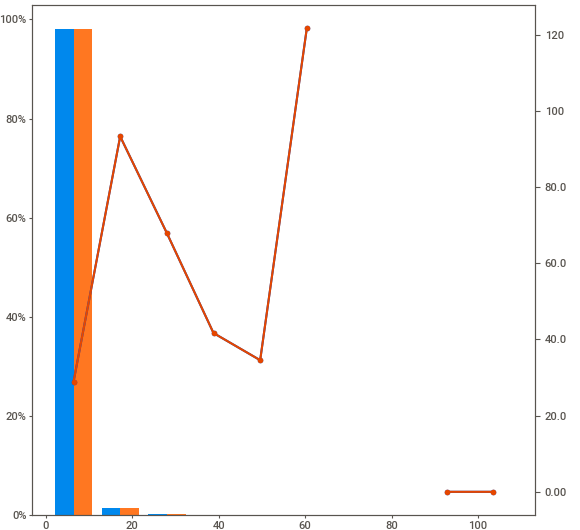
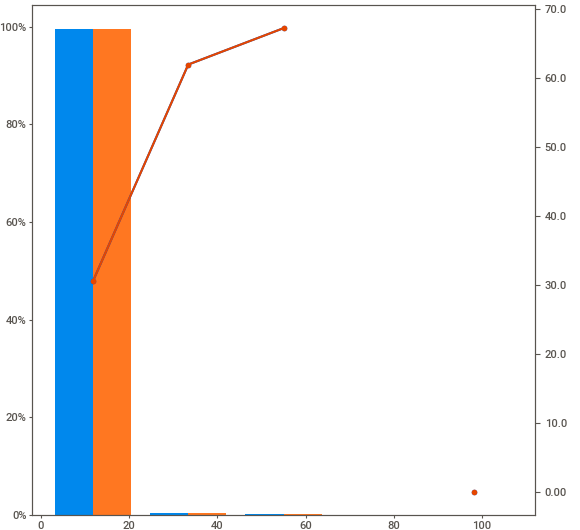
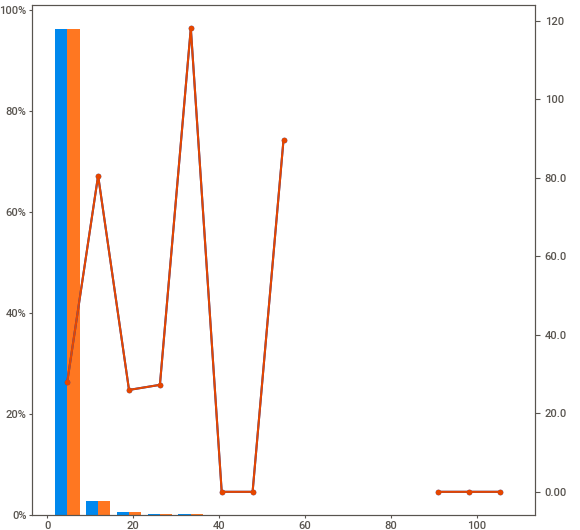
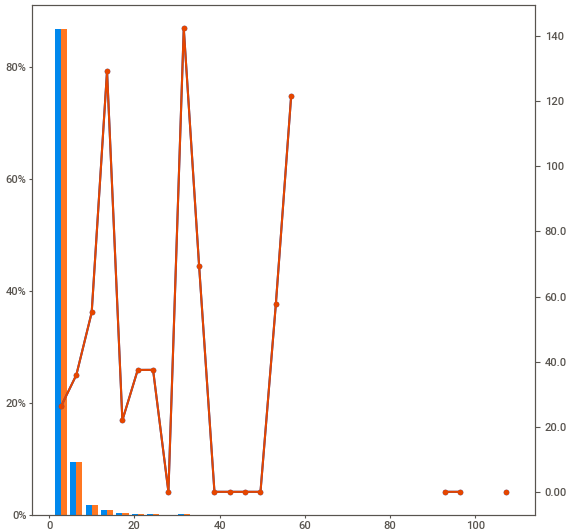
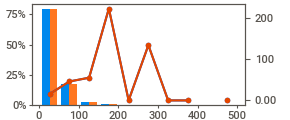
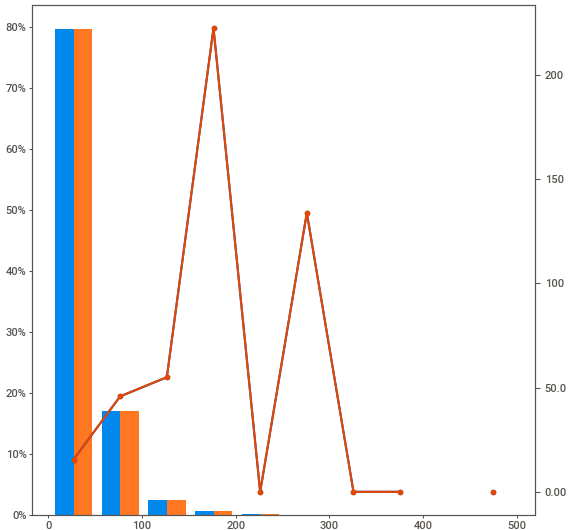
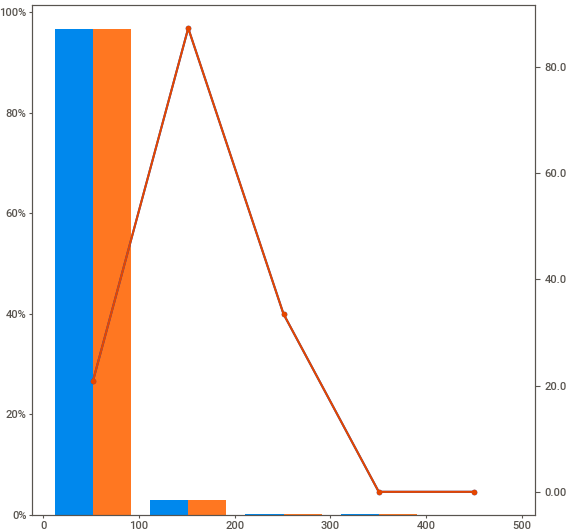
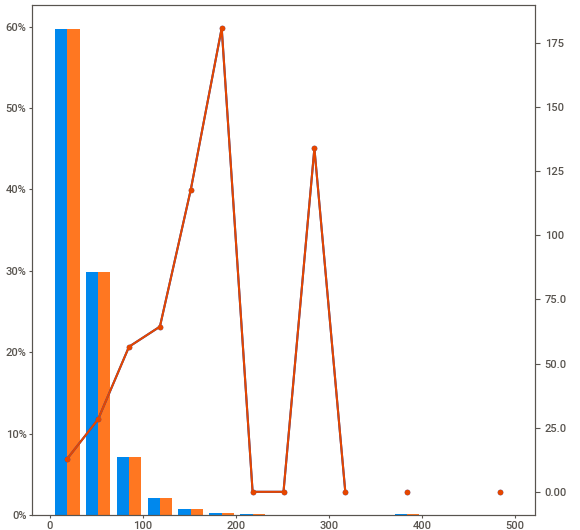
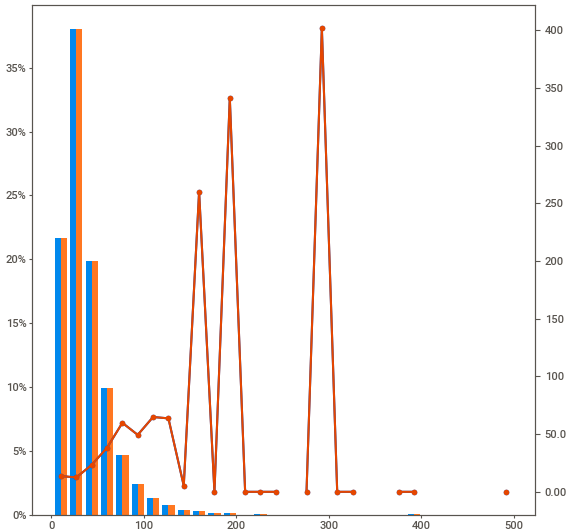
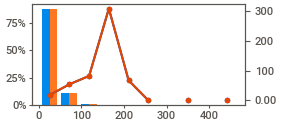
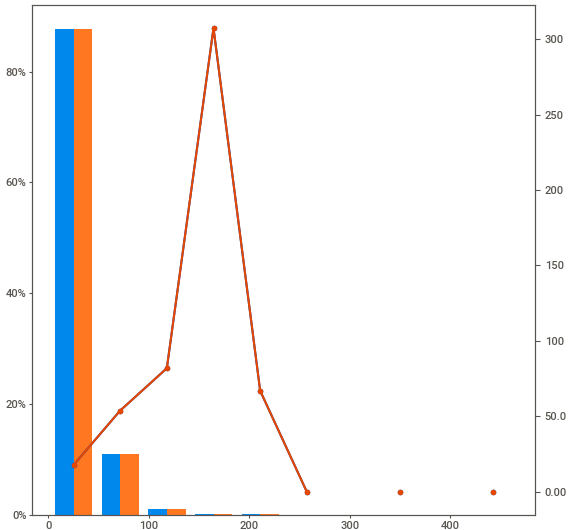
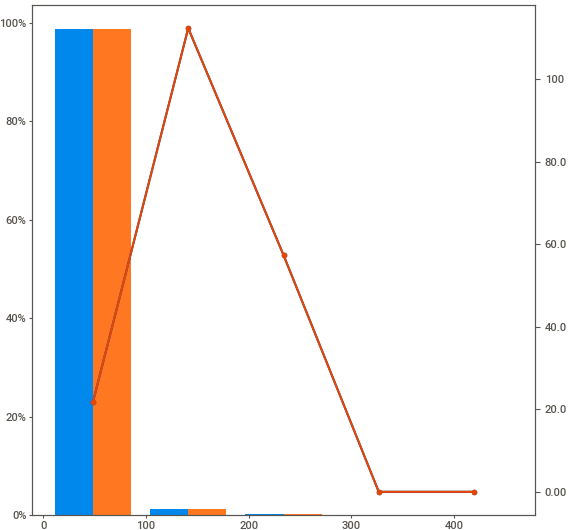
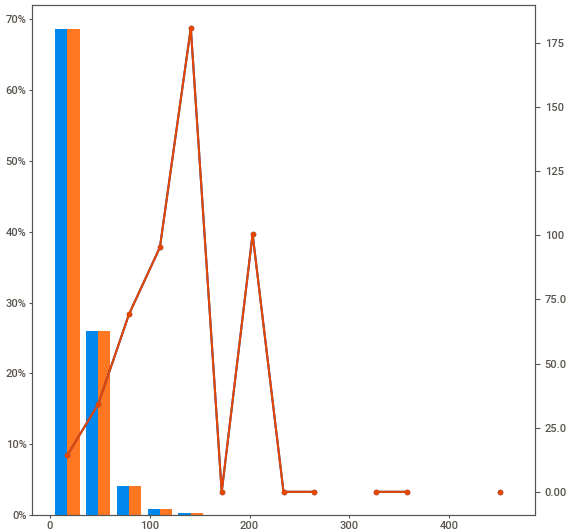
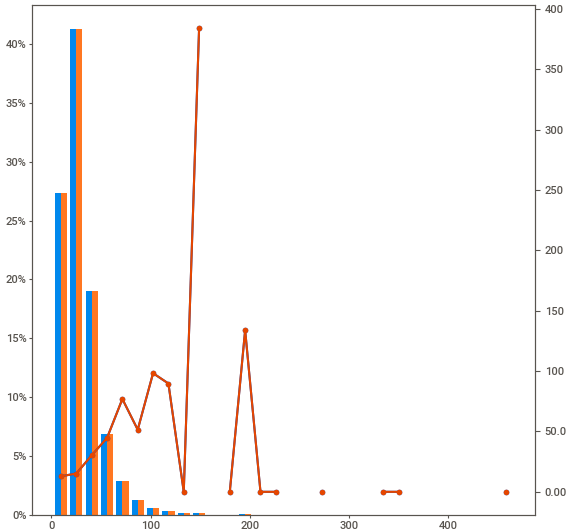
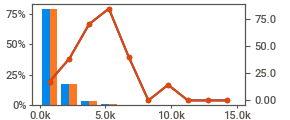
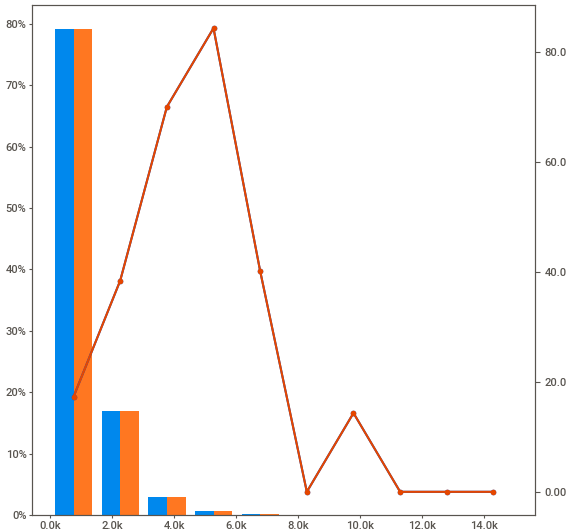
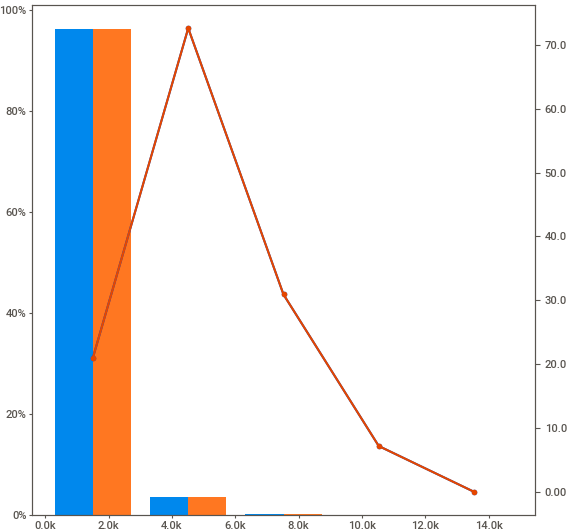
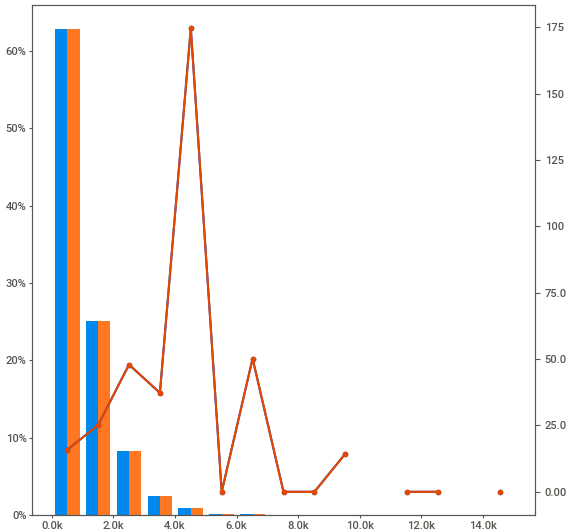
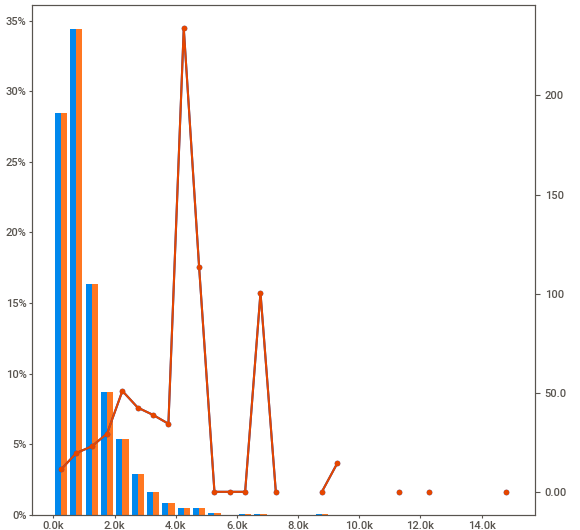
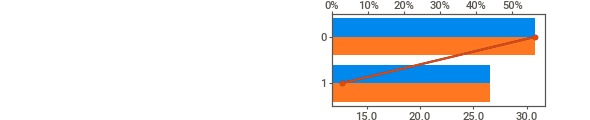
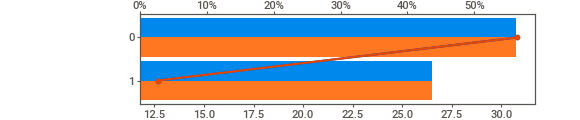
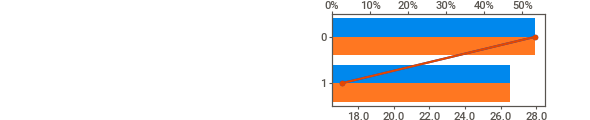
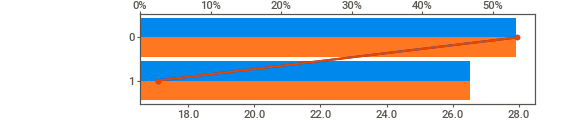
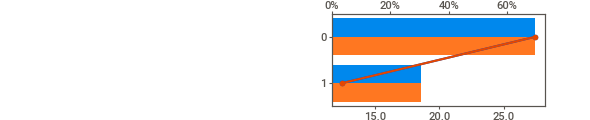
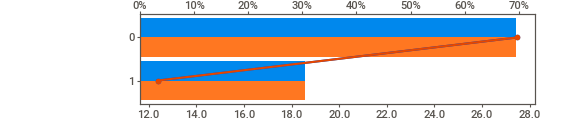
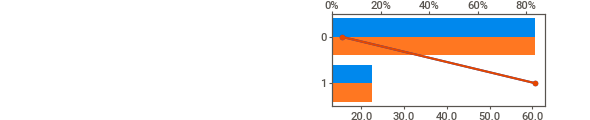
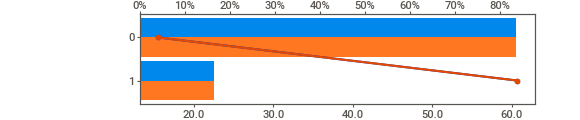
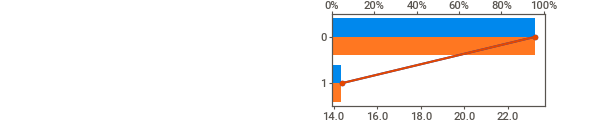
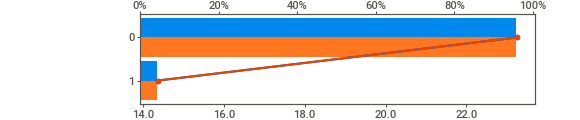
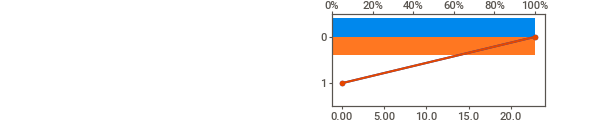
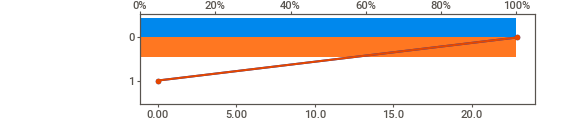
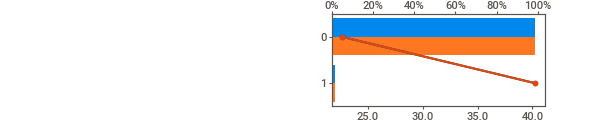
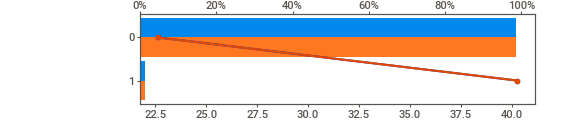
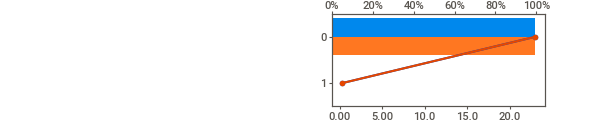
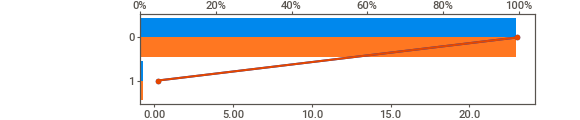
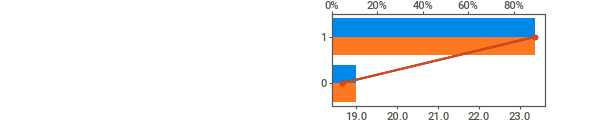
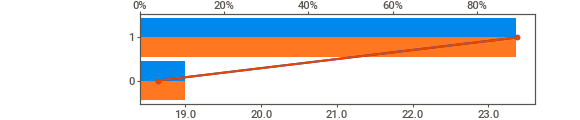
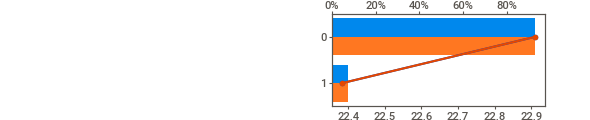
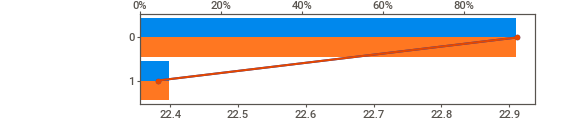
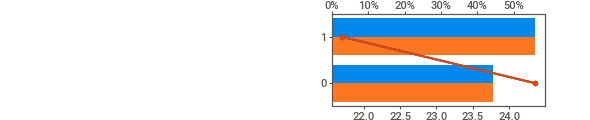
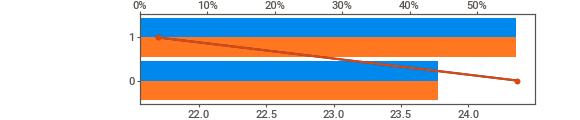
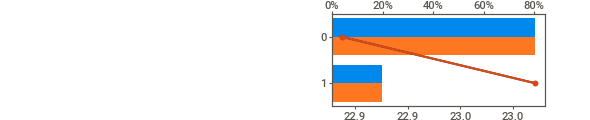
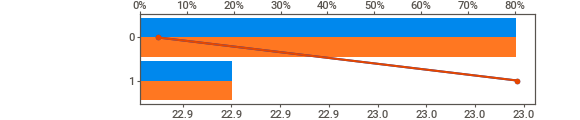
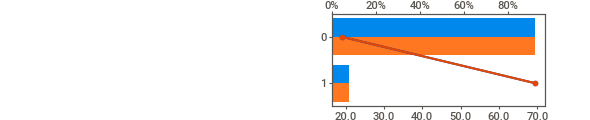
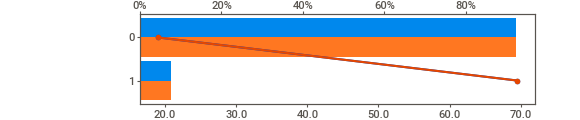
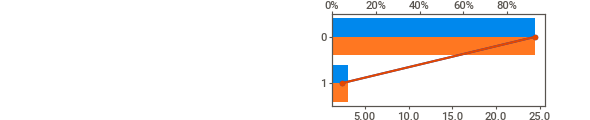
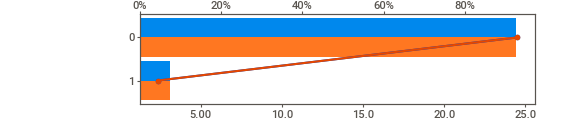
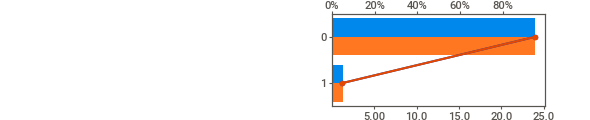
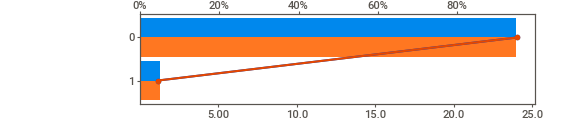
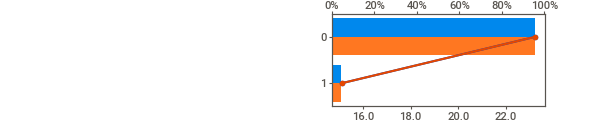
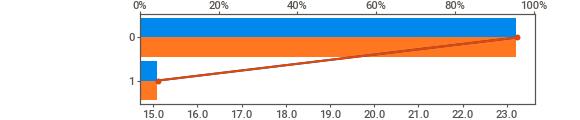
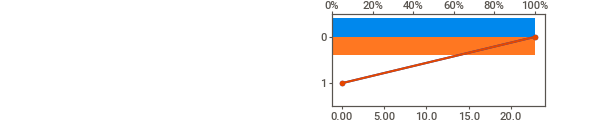
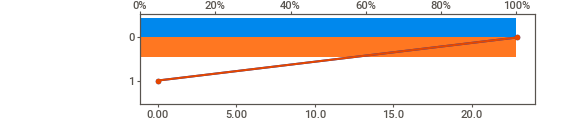
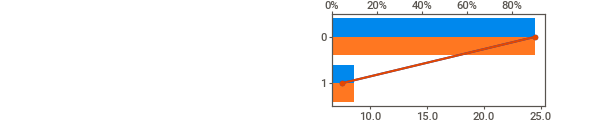
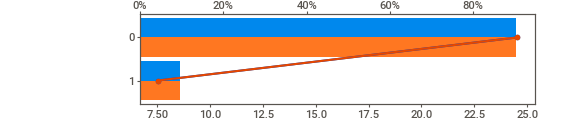
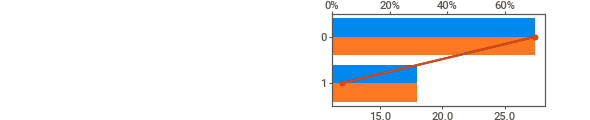
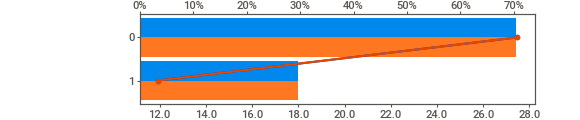
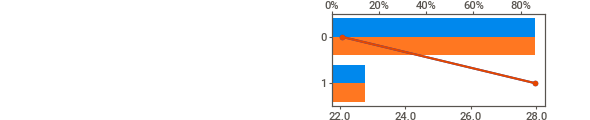
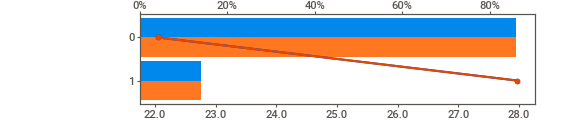
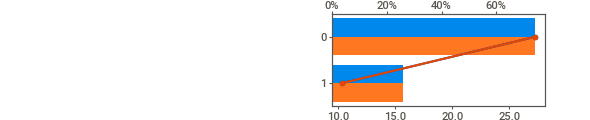
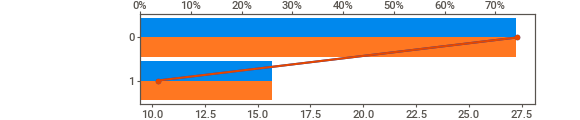
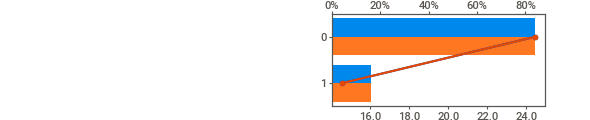
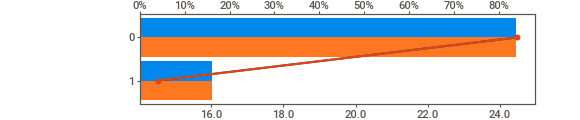
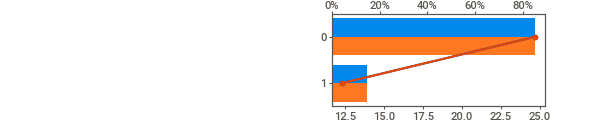
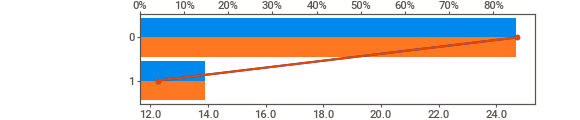
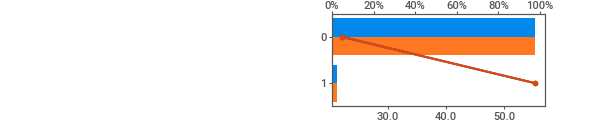
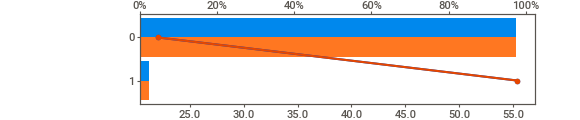
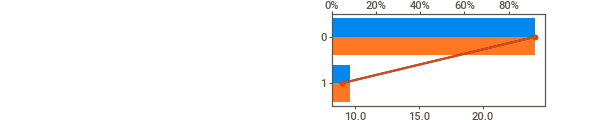
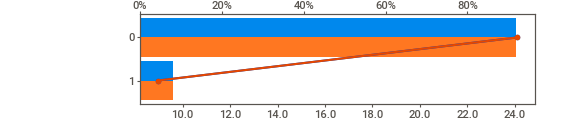
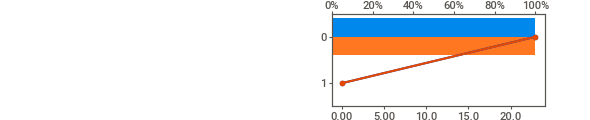
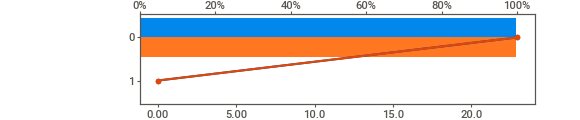
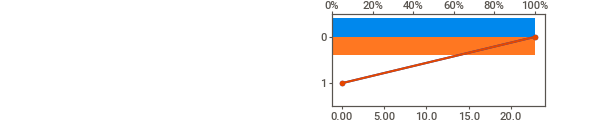
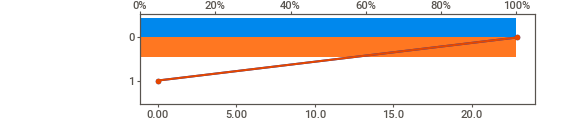
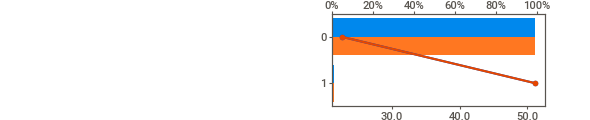
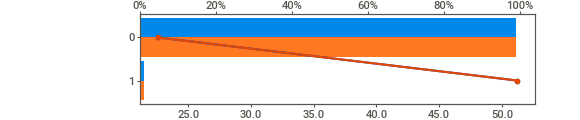
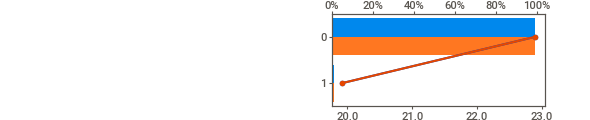
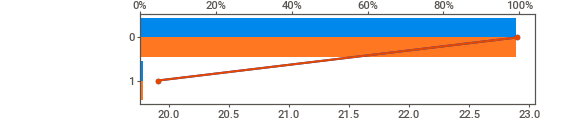
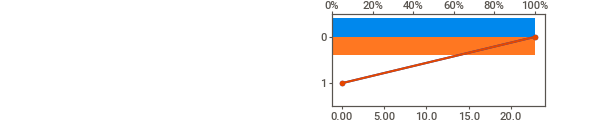
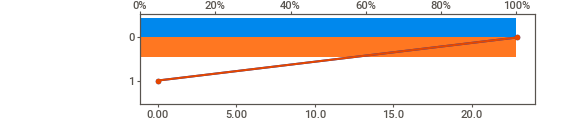
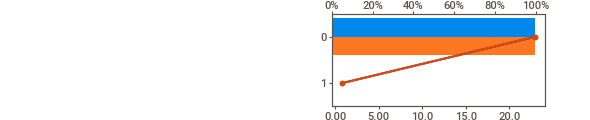
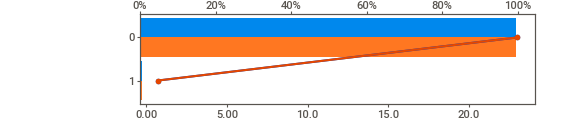
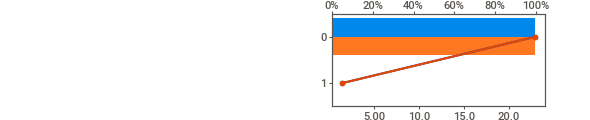
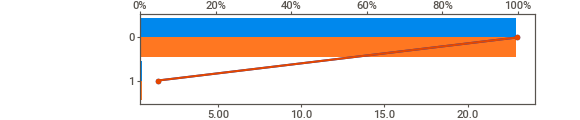
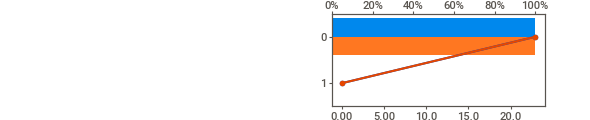
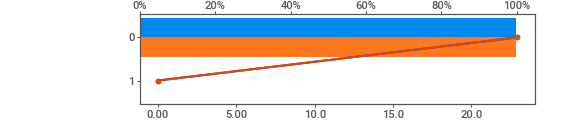
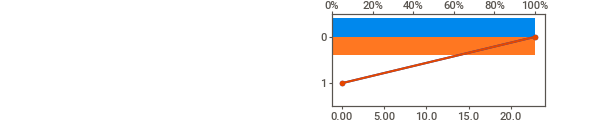
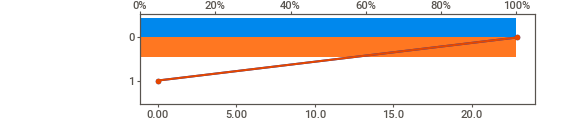
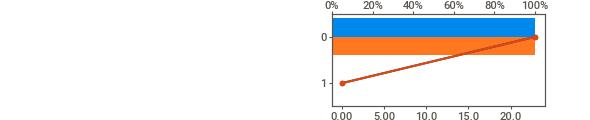
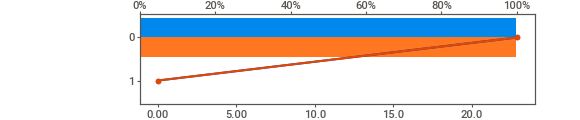
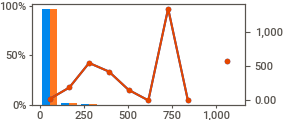
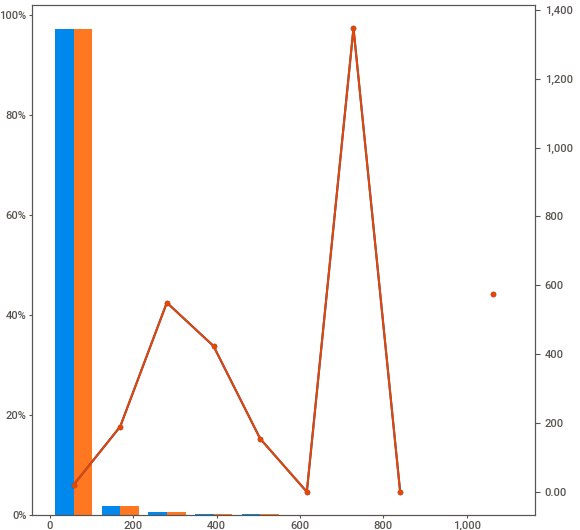
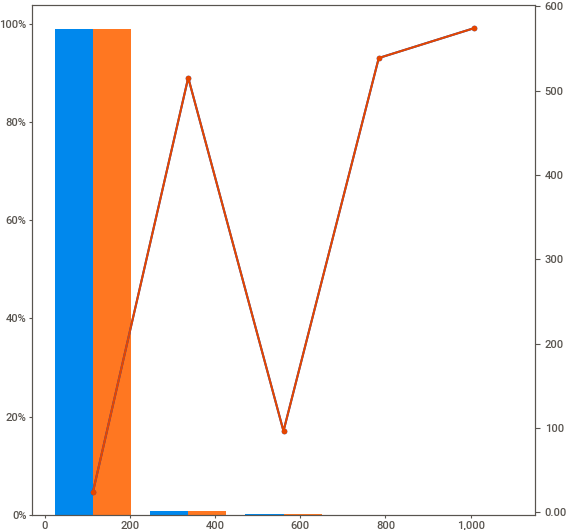
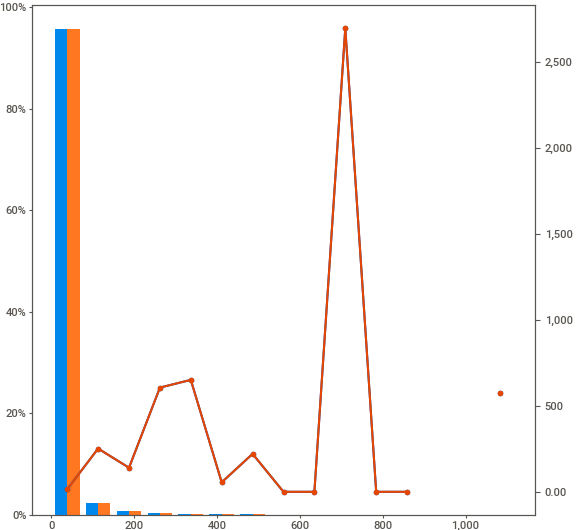
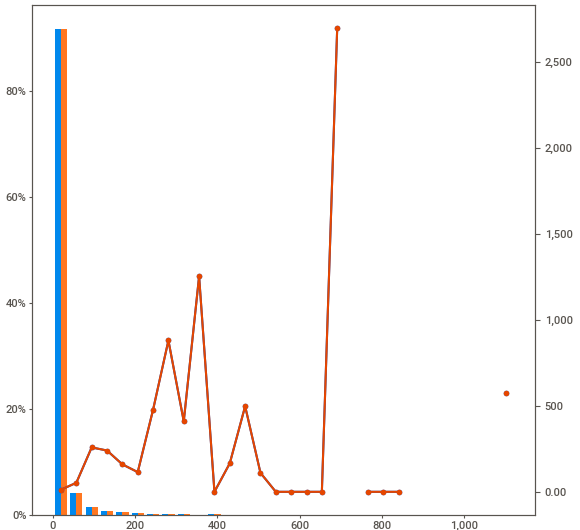
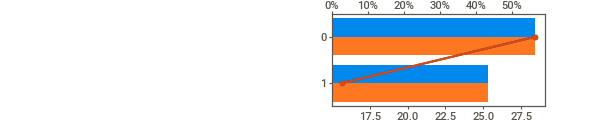
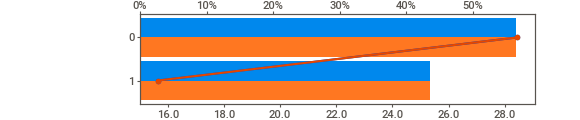
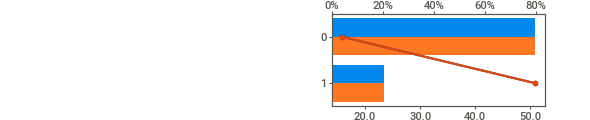
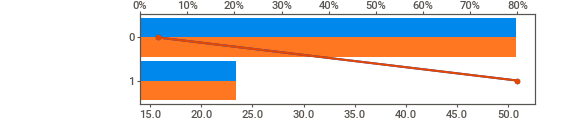
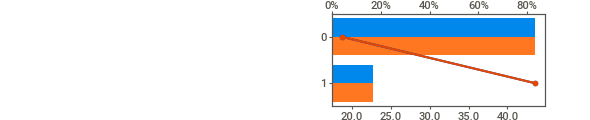
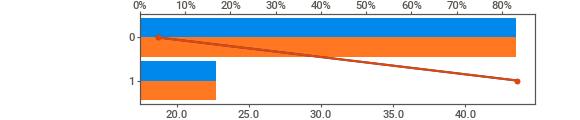
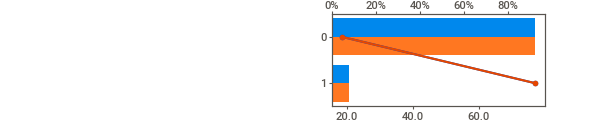
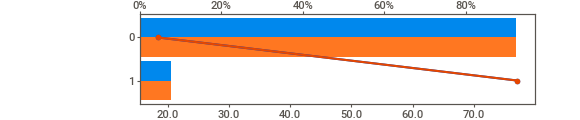
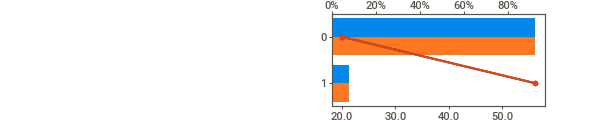
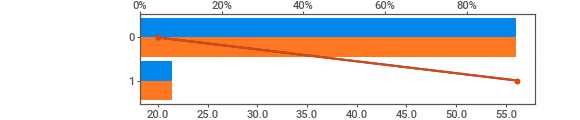
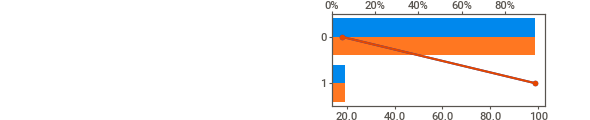
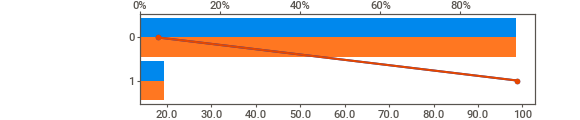
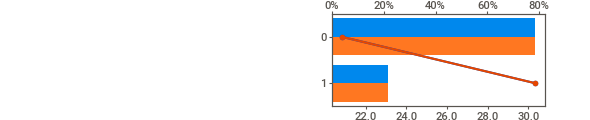
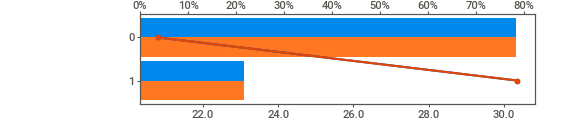
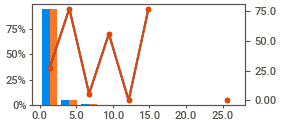
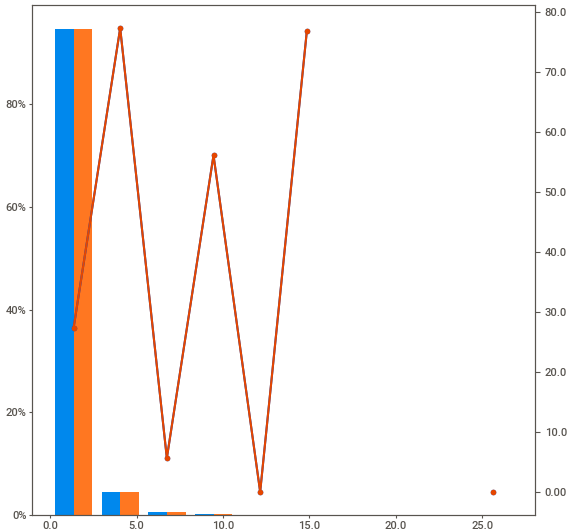
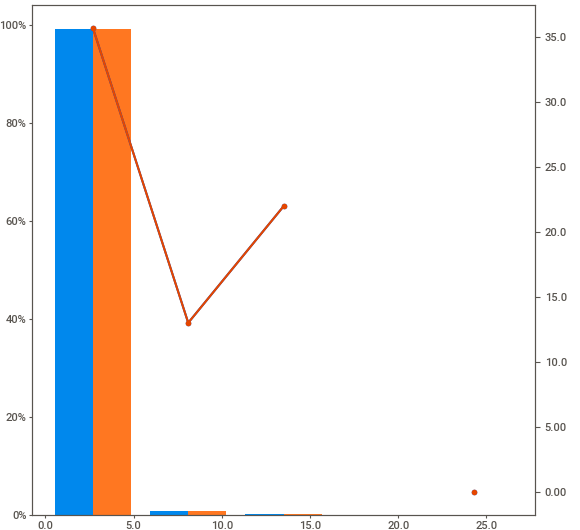
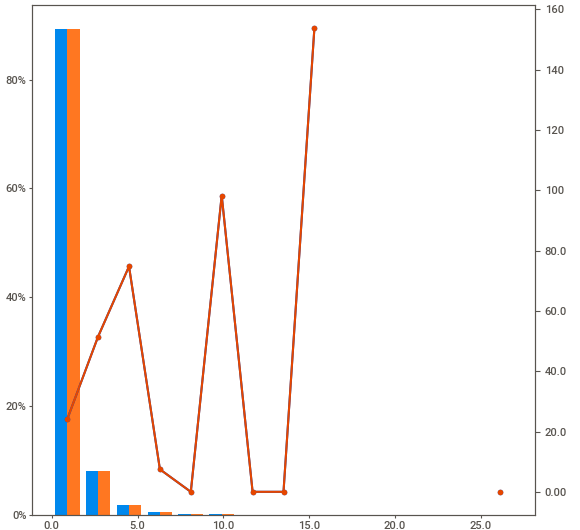
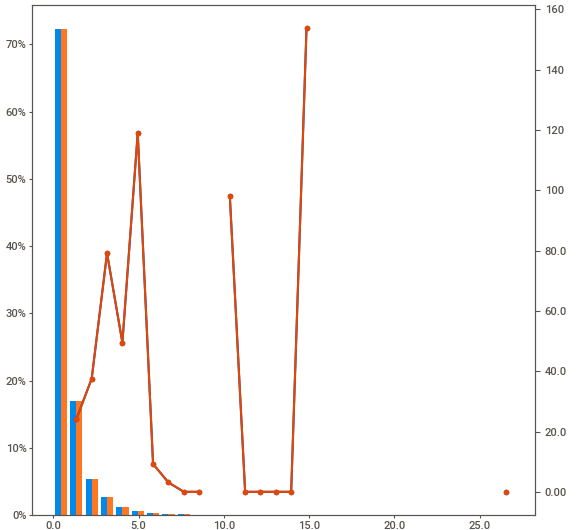
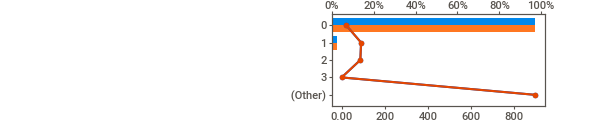
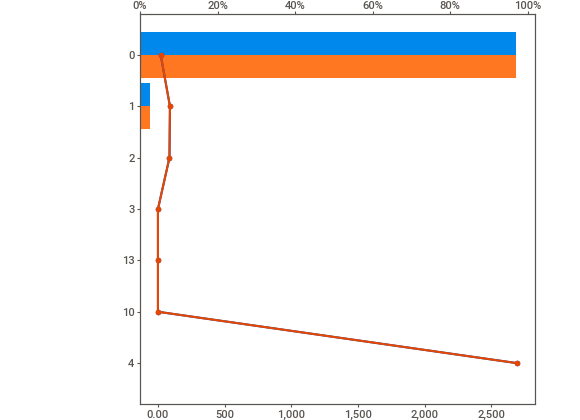
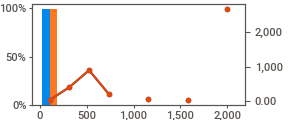
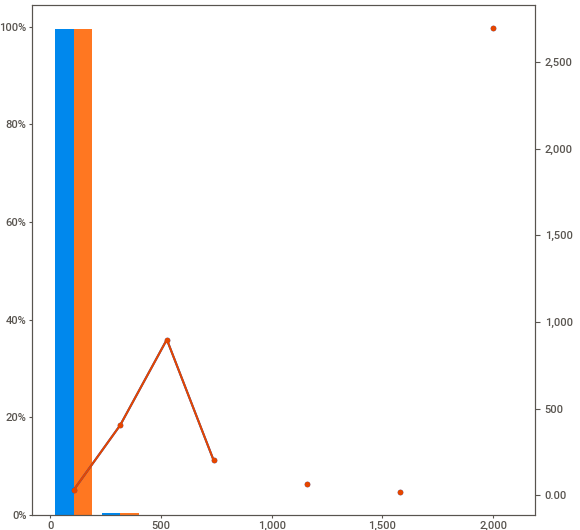
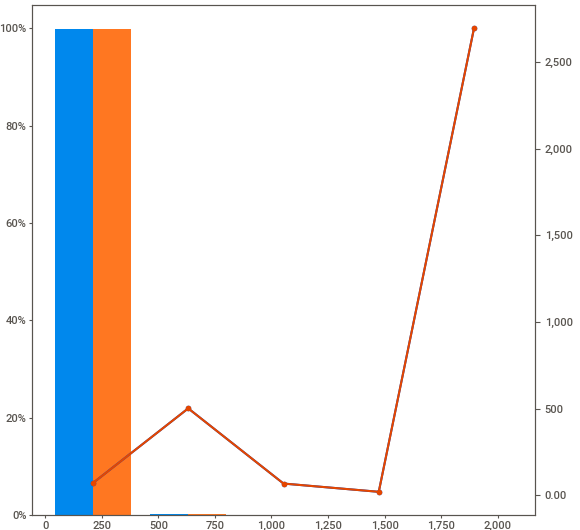
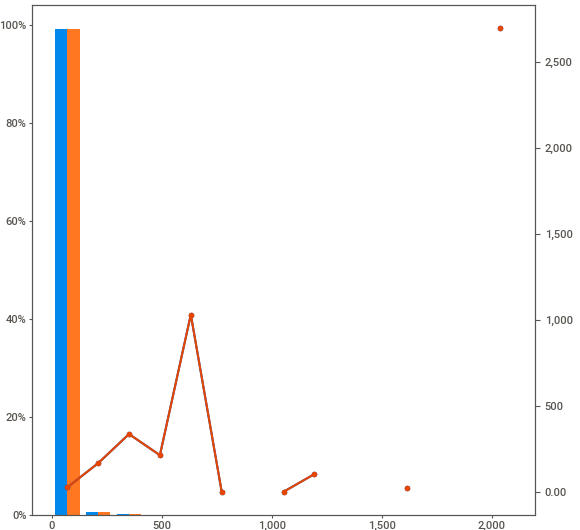
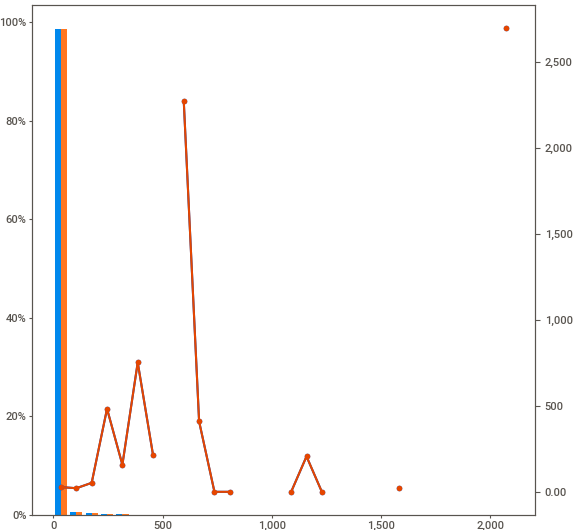
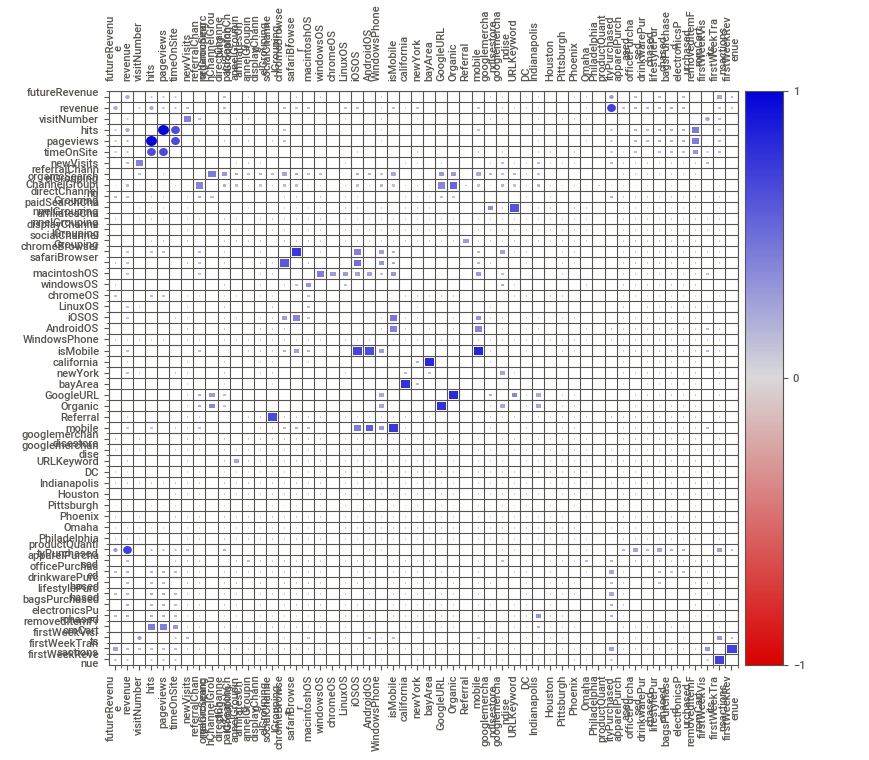
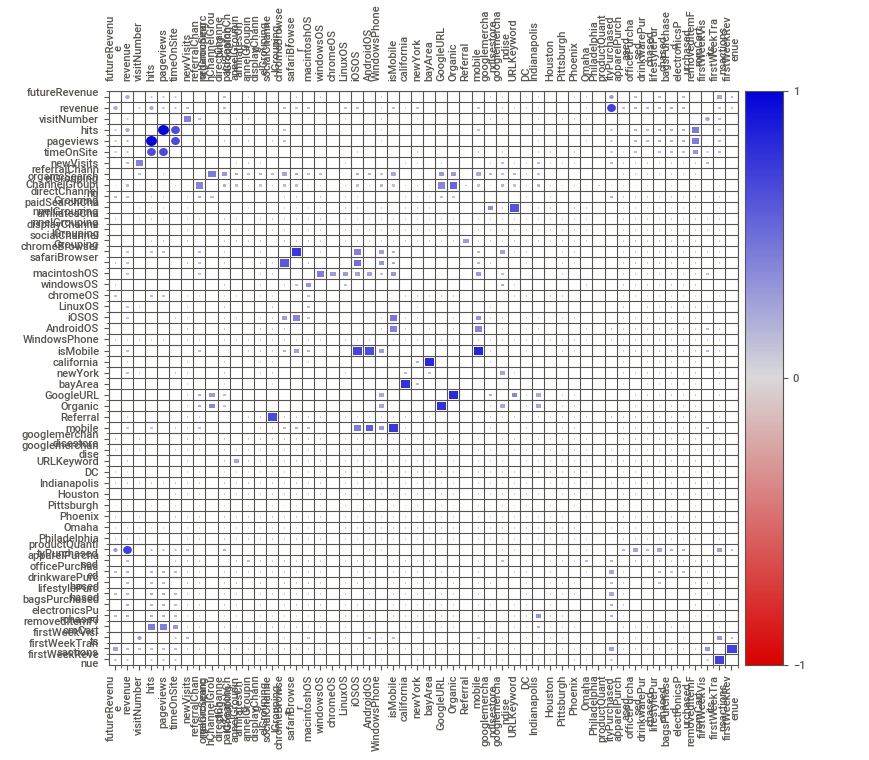

In [ ]:
# Drop records with outlier values and re-do EDA
eda_data_v2 = eda_data.drop(
                    eda_data[(eda_data['futureRevenue'] >= 10000.00) 
                    | (eda_data['revenue'] >= 10000.00)
                    | (eda_data['visitNumber'] >= 150) 
                    | (eda_data['productQuantityPurchased'] >= 1500)].index)

eda_data_v2 = eda_data_v2.reset_index(drop=True)
#Trying out datasets comparing feature of Sweetviz
eda_report_v2=sv.compare([eda_data_v2, 'hit'], [eda_data_v2,'timeOnSite'], target_feat='futureRevenue', pairwise_analysis='on')
eda_report_v2.show_html('Advertising.html')
IPython.display.HTML('Advertising.html')

## Model training

In [ ]:
# Replaced XGBoost with Lightgbm
!pip install lightgbm
!pip install yellowbrick
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, RandomTreesEmbedding
from sklearn.metrics import roc_auc_score, r2_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from hyperopt import hp, tpe
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import ResidualsPlot

### Initial model

avg training true:  24.307530537459286
avg training pred:  7.981875277057558

Training RMSE:  179.79
Training R-Squared:  0.06

Testing RMSE:  106.1
Testing R-Squared:  0.1

Prediction Error Plot


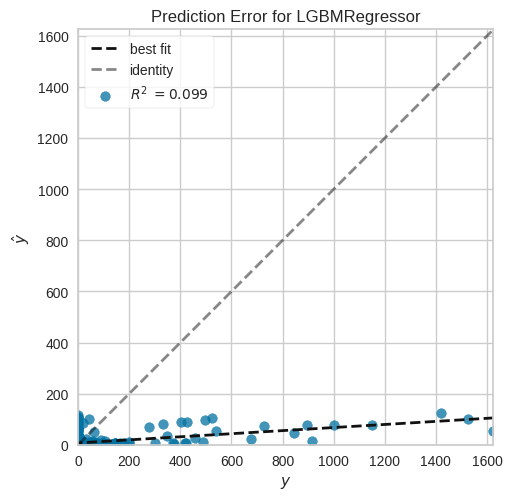


Initial Model MAE:  17.48
Initial Model RMSE:  68.96
Initial Model Avg Error:  5.21


In [ ]:
# Drop the same rows dropped during EDA
dev_data = dev_data.drop(
                    dev_data[(dev_data['futureRevenue'] >= 10000.00) 
                    | (dev_data['revenue'] >= 10000.00)
                    | (dev_data['visitNumber'] >= 150) 
                    | (dev_data['productQuantityPurchased'] >= 1500)].index)

dev_data = dev_data.reset_index(drop=True)

# Setup the data for SK Learn
X = dev_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue'], axis=1) # Feature matrix in pd.DataFrame format...fullVisitorId, session time, and future revenue aren't being used as predictor variables
y = pd.Series(dev_data.futureRevenue) # Target vector in pd.Series format

# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# Instantiate Lightgbm object with hyperparameters; 
# Replace gbdt with dart
# Tuned max_depth, n_estimators, reg_alpha, reg_lamba, learning_rate; 
# Added bagging_fraction, feature_fraction, bagging_freq, bagging_seed, verbosity
model = lgb.LGBMRegressor(max_depth=4, n_estimators=470,
                           reg_alpha=0, reg_lambda=0,
                           objectvie='reg:squarederror', boosting_type='dart',
                           random_state=123, learning_rate=0.00225, bagging_fraction=0.8, feature_fraction=0.7,
        bagging_freq=1, bagging_seed=2018, verbosity=-1, )


#model = LinearRegression()
#model = DecisionTreeRegressor(max_depth=3)

# Fit the data(train the model)
model.fit(X_train, y_train,)



# Calculate RMSE and R^2 for training data
train_y_pred = model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

print("avg training true: ", np.mean(train_y_true))
print("avg training pred: ", np.mean(train_y_pred))

Training_MSE = mse(train_y_true, train_y_pred)
Training_RMSE = np.sqrt(Training_MSE)

Training_R_squared = r2_score(train_y_true, train_y_pred)

# Calculate RMSE and R^2 for testing data
test_y_pred = model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

Testing_MSE = mse(test_y_true, test_y_pred)
Testing_RMSE = np.sqrt(Testing_MSE)

Testing_R_squared = r2_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("\nTraining RMSE: ", np.round(Training_RMSE, 2))
print("Training R-Squared: ", np.round(Training_R_squared, 2))

print("\nTesting RMSE: ", np.round(Testing_RMSE, 2))
print("Testing R-Squared: ", np.round(Testing_R_squared, 2))

# Visualize the Prediction Error Plot
print("\nPrediction Error Plot")
viz = prediction_error(model, X_train, y_train, X_test, y_test)
viz.show() # Sometimes visualization fails after using PyCaret EDA... Have to restart runtime and skip EDA

X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue'], axis=1) 
y_holdout = pd.Series(holdout_data.futureRevenue)

holdout_y_pred = model.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout

# Get RMSE, MAE, and average error based on initial model predictions
Initial_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
Initial_Model_MSE = mse(holdout_y_true, holdout_y_pred)
Initial_Model_RMSE = np.sqrt(Initial_Model_MSE)
Initial_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

print("\nInitial Model MAE: ", np.round(Initial_Model_MAE, 2))
print("Initial Model RMSE: ", np.round(Initial_Model_RMSE, 2))
print("Initial Model Avg Error: ", np.round(Initial_Model_Avg_Error, 2))

### Regression model (repeat purchasers only)

In [ ]:
# Also drop any rows where futureRevenue = 0
reg_data = dev_data.drop(
                    dev_data[(dev_data['futureRevenue'] >= 10000.00) 
                    | (dev_data['revenue'] >= 10000.00)
                    | (dev_data['visitNumber'] >= 100) 
                    | (dev_data['productQuantityPurchased'] >= 1000)
                    | (dev_data['futureRevenue'] == 0)].index)

reg_data = reg_data.reset_index(drop=True)

# Look at correlation between futureRevenue and other variables to select initial feature set
reg_data[reg_data.columns[1:]].corr()['futureRevenue'][:-1]

revenue                         0.362663
visitNumber                     0.045339
hits                            0.187032
pageviews                       0.200819
timeOnSite                      0.168338
newVisits                      -0.029252
referralChannelGrouping        -0.196190
organicSearchChannelGrouping   -0.057873
directChannelGrouping           0.274020
paidSearchChannelGrouping       0.025719
affiliatesChannelGrouping            NaN
displayChannelGrouping          0.026834
socialChannelGrouping          -0.025728
chromeBrowser                  -0.037515
safariBrowser                   0.076230
macintoshOS                    -0.146410
windowsOS                       0.059102
chromeOS                        0.207824
LinuxOS                        -0.081161
iOSOS                          -0.070330
AndroidOS                       0.046967
WindowsPhone                         NaN
isMobile                       -0.024147
california                     -0.131329
newYork         


Training RMSE:  380.6
Training R-Squared:  0.5

Testing RMSE:  595.47
Testing R-Squared:  0.2

Prediction Error Plot


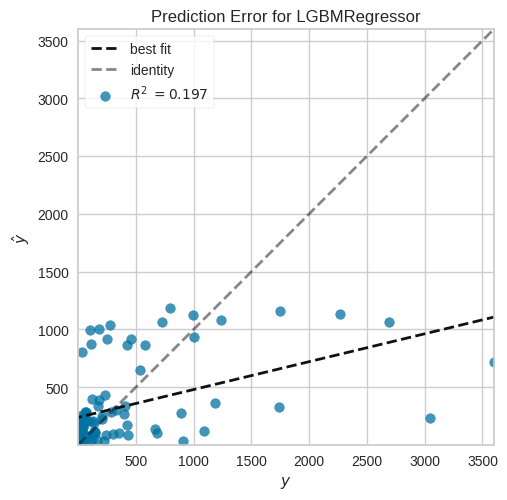

In [ ]:
# Setup the data for SK Learn

# Feature matrix will include variables with largest correlations to futureRevenue
X = reg_data[['revenue','pageviews','referralChannelGrouping','directChannelGrouping','electronicsPurchased','officePurchased','chromeOS','productQuantityPurchased','firstWeekRevenue']]
y = pd.Series(reg_data.futureRevenue) # Target vector in pd.Series format



# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# Instantiate XGBoost object with hyperparameters...No hyperparameter tuning is included in this example but would be beneficial
reg_model = lgb.LGBMRegressor(max_depth=1, n_estimators=1000,
                           reg_alpha=100, reg_lambda=10,
                           objectvie='reg:squarederror', booster='gdbtree',
                           random_state=123, learning_rate=0.10)

#reg_model = LinearRegression()
#reg_model = DecisionTreeRegressor(max_depth=3)

# Fit the data(train the model)
reg_model.fit(X_train, y_train)

# Get RMSE and R^2 for training data
train_y_pred = reg_model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

Training_MSE = mse(train_y_true, train_y_pred)
Training_RMSE = np.sqrt(Training_MSE)

Training_R_squared = r2_score(train_y_true, train_y_pred)

# Get RMSE and R^2 for testing data
test_y_pred = reg_model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

Testing_MSE = mse(test_y_true, test_y_pred)
Testing_RMSE = np.sqrt(Testing_MSE)

Testing_R_squared = r2_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("\nTraining RMSE: ", np.round(Training_RMSE, 2))
print("Training R-Squared: ", np.round(Training_R_squared, 2))

print("\nTesting RMSE: ", np.round(Testing_RMSE, 2))
print("Testing R-Squared: ", np.round(Testing_R_squared, 2))

# Visualize the Prediction Error Plot
print("\nPrediction Error Plot")
viz = prediction_error(reg_model, X_train, y_train, X_test, y_test)
viz.show()

### Classification model (likelihood to purchase again)

In [ ]:
# Drop the same rows dropped during EDA
# We will include both repeat purchasers and single purchasers here since we're trying to predict repeat purchase
cla_data = dev_data.drop(
                    dev_data[(dev_data['futureRevenue'] >= 10000.00) 
                    | (dev_data['revenue'] >= 10000.00)
                    | (dev_data['visitNumber'] >= 100) 
                    | (dev_data['productQuantityPurchased'] >= 1000)].index)

# Add column to represent a user that purchased again
# This will be our model's target
cla_data['repeatPurchaser'] = np.where(cla_data['futureRevenue'] > 0, 1, 0)

dev_data = dev_data.reset_index(drop=True)

# Look at correlation between repeatPurchaser and other variables to select initial feature set
# Correlation isn't the best metric to look at for a classification problem. 
# Feel free to use another technique to select your intial features.
cla_data[cla_data.columns[1:]].corr()['repeatPurchaser'][:-1]

revenue                         0.120940
visitNumber                     0.088569
hits                            0.069451
pageviews                       0.063192
timeOnSite                      0.053665
newVisits                      -0.095229
referralChannelGrouping         0.029061
organicSearchChannelGrouping   -0.058179
directChannelGrouping           0.050635
paidSearchChannelGrouping      -0.030333
affiliatesChannelGrouping      -0.007945
displayChannelGrouping          0.010214
socialChannelGrouping          -0.015809
chromeBrowser                   0.032709
safariBrowser                  -0.031003
macintoshOS                     0.051852
windowsOS                      -0.025082
chromeOS                        0.040661
LinuxOS                        -0.041832
iOSOS                          -0.038398
AndroidOS                      -0.035238
WindowsPhone                   -0.003552
isMobile                       -0.052903
california                     -0.022611
newYork         

In [ ]:
# Setup the data for SK Learn

# Feature matrix will include variables with largest correlations to repeatVisitor (excluding futureRevenue, which we can't use)
X = cla_data[['revenue','productQuantityPurchased', 'firstWeekRevenue']]
y = pd.Series(cla_data.repeatPurchaser) # Target vector in pd.Series format



# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# Instantiate XGBoost object with hyperparameters...No hyperparameter tuning is included in this example but would be beneficial
cla_model = lgb.LGBMClassifier(max_depth=5, n_estimators=100,
                           reg_alpha=0.5, reg_lambda=0,
                           objective="binary", booster='gbtree',
                           random_state=123, learning_rate=0.1)
#cla_model = LogisticRegression()
#cla_model = DecisionTreeClassifier()

# Fit the data(train the model)
cla_model.fit(X_train, y_train)

# Calculate evaluation metrics for classification model
train_y_pred = cla_model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

test_y_pred = cla_model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data


print('\n clasification report:\n', classification_report(test_y_true, test_y_pred))
print('\n confussion matrix:\n',confusion_matrix(test_y_true, test_y_pred))
print('\n ROC AUC: \n',roc_auc_score(test_y_true, test_y_pred))


 clasification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1149
           1       0.50      0.01      0.02        79

    accuracy                           0.94      1228
   macro avg       0.72      0.51      0.50      1228
weighted avg       0.91      0.94      0.91      1228


 confussion matrix:
 [[1148    1]
 [  78    1]]

 ROC AUC: 
 0.5058939529144771


### Holdout predictions

Comparing different options for making a prediction to a "naive estimate." The three options I will consider for making a prediction are:
- Naive estimate, which assumes each customer's 8-90 day future revenue will be equal to the average future revenue observed in the development dataset.
- Initial model's predictions. This was the first model with the low R-squared.
- Regression only model, which will take the predictions from the regression model trained on repeat purchasers multiplied by the average repeat purchase rate observered in the development dataset. 

Evaluate the model based on three metrics:
- Mean absolute error, the primary KPI
- Mean squared error, which is more sensitive to extreme errors
- Average error, which will indicate overall prediction bias

In [ ]:
# Calculate average repeat purchase rate from development dataset
dev_data['repeatPurchaser'] = np.where(dev_data['futureRevenue'] > 0, 1, 0)
AvgRepeat = np.mean(dev_data['repeatPurchaser'])

# Calculate average future revenue observed in the development dataset
AvgCLV = np.mean(dev_data['futureRevenue']) 

# Create naive estimate for all customers, which is equal to average future revenue from development dataset
holdout_data['NaiveEstimate'] = AvgCLV 

# Set up holdout data for initial model
X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate'], axis=1) 
y_holdout = pd.Series(holdout_data.futureRevenue)

holdout_y_pred = model.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout # True values for holdout data

# Set up data for regression only model
reg_X_holdout = holdout_data[['revenue','pageviews','referralChannelGrouping','directChannelGrouping','electronicsPurchased','officePurchased','chromeOS','productQuantityPurchased','firstWeekRevenue']]

reg_holdout_y_pred = reg_model.predict(reg_X_holdout) * AvgRepeat # Regression only predictions for holdout data


# Get RMSE and MAE error based on naive estimate
Naive_MAE = np.mean(np.absolute(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true))
Naive_MSE = mse(pd.Series(holdout_data.NaiveEstimate), holdout_y_true)
Naive_RMSE = np.sqrt(Naive_MSE)
Naive_Avg_Error = np.mean(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true)

# Get RMSE, MAE, and average error based on initial model predictions
Initial_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
Initial_Model_MSE = mse(holdout_y_true, holdout_y_pred)
Initial_Model_RMSE = np.sqrt(Initial_Model_MSE)
Initial_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

# Get RMSE and MAE error based on regression only model
Reg_Model_MAE = np.mean(np.absolute(holdout_y_true - reg_holdout_y_pred))
Reg_Model_MSE = mse(holdout_y_true, reg_holdout_y_pred)
Reg_Model_RMSE = np.sqrt(Reg_Model_MSE)
Reg_Model_Avg_Error = np.mean(reg_holdout_y_pred - holdout_y_true)

print("\nNaive MAE: ", np.round(Naive_MAE, 2))
print("Naive RMSE: ", np.round(Naive_RMSE, 2))
print("Naive Avg Error: ", np.round(Naive_Avg_Error, 2))

print("\nInitial Model MAE: ", np.round(Initial_Model_MAE, 2))
print("Initial Model RMSE: ", np.round(Initial_Model_RMSE, 2))
print("Initial Model Avg Error: ", np.round(Initial_Model_Avg_Error, 2))

print("\nRegression Only Model MAE: ", np.round(Reg_Model_MAE, 2))
print("Regression Only Model RMSE: ", np.round(Reg_Model_RMSE, 2))
print("Regression Only Model Avg Error: ", np.round(Reg_Model_Avg_Error, 2))




Naive MAE:  31.59
Naive RMSE:  70.2
Naive Avg Error:  10.83

Initial Model MAE:  17.48
Initial Model RMSE:  68.96
Initial Model Avg Error:  5.21

Regression Only Model MAE:  20.71
Regression Only Model RMSE:  69.09
Regression Only Model Avg Error:  -1.16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
